In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

def get_fund_k_history(fund_code: str, pz: int = 4000) -> pd.DataFrame:
    '''
    根据基金代码和要获取的页码抓取基金净值信息

    Parameters
    ----------
    fund_code : 6位基金代码
    page : 页码 1 为最新页数据

    Return
    ------
    DataFrame : 包含基金历史k线数据
    '''
    # 请求头
    EastmoneyFundHeaders = {
        'User-Agent': 'EMProjJijin/6.2.8 (iPhone; iOS 13.6; Scale/2.00)',
        'GTOKEN': '98B423068C1F4DEF9842F82ADF08C5db',
        'clientInfo': 'ttjj-iPhone10,1-iOS-iOS13.6',
        'Content-Type': 'application/x-www-form-urlencoded',
        'Host': 'fundmobapi.eastmoney.com',
        'Referer': 'https://mpservice.com/516939c37bdb4ba2b1138c50cf69a2e1/release/pages/FundHistoryNetWorth',
    }
    # 请求参数
    data = {
        'FCODE': f'{fund_code}',
        'appType': 'ttjj',
        'cToken': '1',
        'deviceid': '1',
        'pageIndex': '1',
        'pageSize': f'{pz}',
        'plat': 'Iphone',
        'product': 'EFund',
        'serverVersion': '6.2.8',
        'version': '6.2.8'
    }
    url = 'https://fundmobapi.eastmoney.com/FundMNewApi/FundMNHisNetList'
    json_response = requests.get(
        url, headers=EastmoneyFundHeaders, data=data).json()
    rows = []
    columns = ['date', 'NAV', 'NAV-Cum', 'change']
    if json_response is None:
        return pd.DataFrame(rows, columns=columns)
    datas = json_response['Datas']
    if len(datas) == 0:
        return pd.DataFrame(rows, columns=columns)
    rows = []
    for stock in datas:
        date = stock['FSRQ']
        rows.append({
            'date': date,
            'NAV': stock['DWJZ'],
            'NAV-Cum': stock['LJJZ'],
            'change': stock['JZZZL']
        })

    df = pd.DataFrame(rows)
    df['NAV'] = pd.to_numeric(df['NAV'], errors='coerce')

    df['NAV-Cum'] = pd.to_numeric(df['NAV-Cum'], errors='coerce')

    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    return df


In [2]:
fund_codes = {
    '007029': "zhongzheng 500", 
    '003318': "500dibo", 
    '007301': "bandaoti - zhongzheng",
    "010956": "zhinengqiche",
#     '008888': "bandaoti - guozheng", 
#     '001592': "chuangyeban", # too similar with zhongzheng 500
    '002984': "huanbao", 
    "018094": "jiqiren",
    '014907': "xiaofeidianzi",
#     '002974': "quanzhixinxi", 
    "008021": "rengongzhineng",
    '007339': "hushen 300", 
    '501050': "shangzheng50AH", 
    '000248': "zhuyaoxiaofei",
    "005064": "jiadian",
    '012808': "ziyuan",
    "007818": "tongxinshebei",
#     '012323': "yiliao", 
#     '008552': "yiyaoweisheng", 
    '002978': "quanzhiyiyao", 
#     '011041': "shengwuyiyao", 
    "012737": "chuangxinyao",
    "501012": "zhongyao",
    '005562': "honglidibo", 
    '009052': "hongli", 
    '017513': "beizheng 50",
    "000307": "huangjinchanye",
    '004753': "chuanmei", 
#     '014425': "hengshengyiliao", 
#     '012348': "hengshengkeji", 
#     '006327': "kweb", 
}

# 遍历基金代码列表获取数据
l_dfs = []
for fund_code in fund_codes:
    # 调用函数获取基金历史净值数据
    fund_data = get_fund_k_history(fund_code)
    fund_data['code'] = fund_code
    fund_data['name'] = fund_codes[fund_code]
    l_dfs.append(fund_data)


df_fund = pd.concat(l_dfs)
df_fund.head()

date     NAV  NAV-Cum change    code            name
0 2024-04-03  1.2380   1.2380   -0.1  007029  zhongzheng 500
1 2024-04-02  1.2393   1.2393  -0.36  007029  zhongzheng 500
2 2024-04-01  1.2438   1.2438   2.08  007029  zhongzheng 500
3 2024-03-29  1.2185   1.2185   1.11  007029  zhongzheng 500
4 2024-03-28  1.2051   1.2051    1.2  007029  zhongzheng 500

In [3]:
print(df_fund.date.max())
print(df_fund.date.min())
print(df_fund.shape)
print(df_fund[df_fund['date']==df_fund.date.max()]['name'].unique())
print(df_fund[df_fund['date']==df_fund.date.max()]['name'].nunique(), len(fund_codes))

# remove kweb, hengshengkeji, hengshengyiliao, yiliao; byebye!

2024-04-03 00:00:00
2015-03-24 00:00:00
(27327, 6)
['zhongzheng 500' '500dibo' 'bandaoti - zhongzheng' 'zhinengqiche'
 'huanbao' 'jiqiren' 'xiaofeidianzi' 'rengongzhineng' 'hushen 300'
 'shangzheng50AH' 'zhuyaoxiaofei' 'jiadian' 'ziyuan' 'tongxinshebei'
 'quanzhiyiyao' 'chuangxinyao' 'zhongyao' 'honglidibo' 'hongli'
 'beizheng 50' 'huangjinchanye' 'chuanmei']
22 22


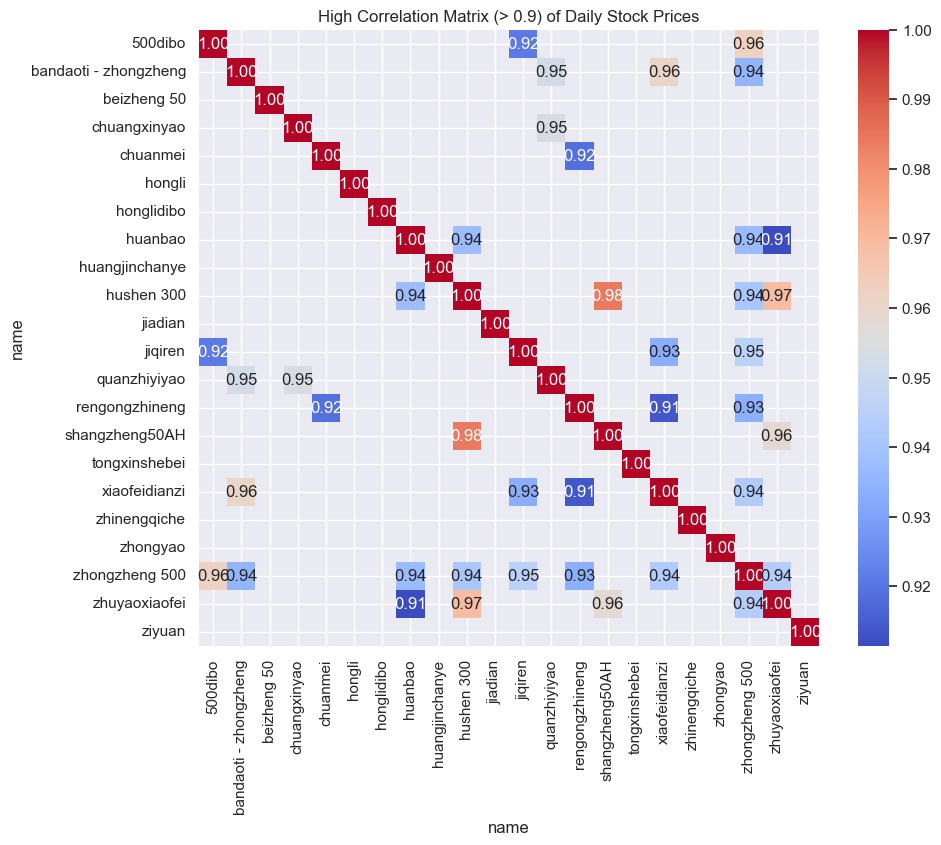

In [4]:
pivot_df = df_fund[df_fund['date']>='2023-04-01'][['date','NAV', 'name']].pivot(index='date', columns='name', values='NAV')
correlation_matrix = pivot_df.corr()

high_correlation = correlation_matrix[correlation_matrix >= 0.91]

plt.figure(figsize=(10, 8))
sns.heatmap(high_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('High Correlation Matrix (> 0.9) of Daily Stock Prices')
plt.show()

In [5]:
df_fund_sub = df_fund[df_fund['date']>='2024-02-05']
print(df_fund_sub.shape)
df_fund_sub['date'] = pd.to_datetime(df_fund_sub['date'])
base_nav = df_fund_sub[df_fund_sub['date'] == '2024-02-05'][['name', 'NAV', 'NAV-Cum']]

# Rename the 'stock_price' column to 'base_price'
base_nav.columns = ['name', 'base_NAV', 'base_NAV-Cum']

# Merge base_prices with the original DataFrame to get base prices for all dates
df_fund_sub = pd.merge(df_fund_sub, base_nav, on='name', how='left')

# Calculate the relative price ratio
df_fund_sub['relative_price'] = df_fund_sub['NAV'] / df_fund_sub['base_NAV']
# df_fund_sub.loc[df_fund_sub['name'] == 'hongli', 'relative_price'] = df_fund_sub.loc[df_fund_sub['name'] == 'hongli', 'NAV-Cum'] / df_fund_sub.loc[df_fund_sub['name'] == 'hongli', 'base_NAV-Cum']

df_fund_sub.head()

(814, 6)


/var/folders/4r/jygz5t7n24724h42lgmbf1hw0000gn/T/ipykernel_78792/3251985981.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fund_sub['date'] = pd.to_datetime(df_fund_sub['date'])


date     NAV  NAV-Cum change    code            name  base_NAV  \
0 2024-04-03  1.2380   1.2380   -0.1  007029  zhongzheng 500    1.0424   
1 2024-04-02  1.2393   1.2393  -0.36  007029  zhongzheng 500    1.0424   
2 2024-04-01  1.2438   1.2438   2.08  007029  zhongzheng 500    1.0424   
3 2024-03-29  1.2185   1.2185   1.11  007029  zhongzheng 500    1.0424   
4 2024-03-28  1.2051   1.2051    1.2  007029  zhongzheng 500    1.0424   

   base_NAV-Cum  relative_price  
0        1.0424        1.187644  
1        1.0424        1.188891  
2        1.0424        1.193208  
3        1.0424        1.168937  
4        1.0424        1.156082

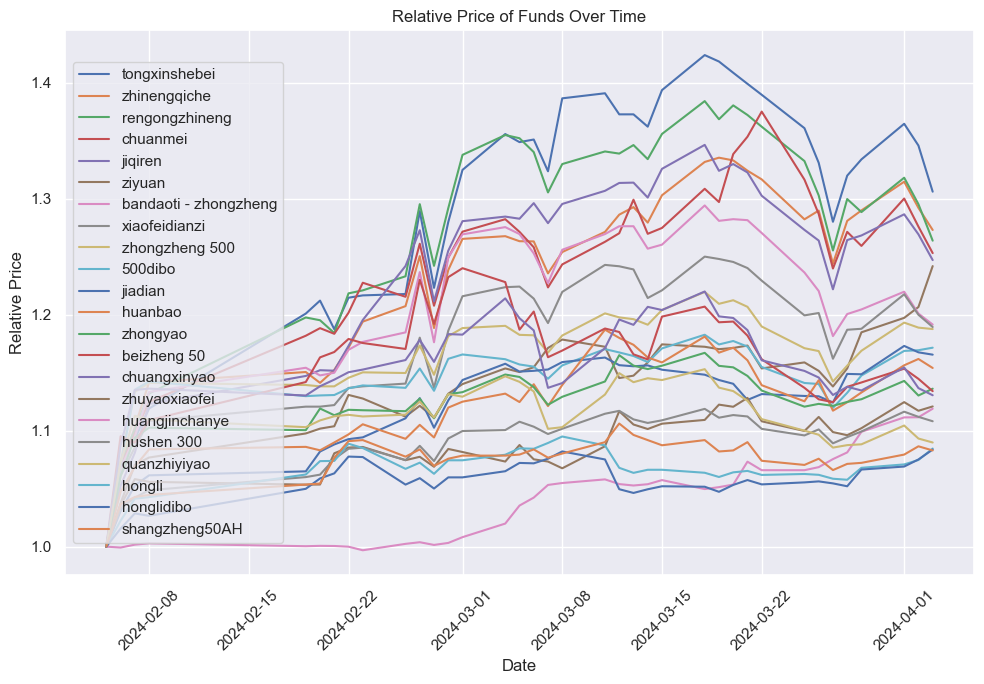

In [6]:
# Assuming df contains the relative_price column and date column is already in datetime format
# Get a list of unique stock names

last_date = df_fund_sub['date'].max()
# Filter the DataFrame to get data only for the last date
last_date_data = df_fund_sub[df_fund_sub['date'] == last_date]
# Sort the data by relative_price in descending order
sorted_data = last_date_data.sort_values(by='relative_price', ascending=False)

# Get the sorted list of stock names
sorted_stock_names = sorted_data['name'].tolist()

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10,7))

# Iterate through each stock and plot its relative price over time
for name in sorted_stock_names:
    fund_data = df_fund_sub[df_fund_sub['name'] == name]
    ax.plot(fund_data['date'], fund_data['relative_price'], label=name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Relative Price')
ax.set_title('Relative Price of Funds Over Time')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
ax.legend(loc='center left')

# Show plot
plt.tight_layout()
plt.show()

In [7]:
# Also check increase rate from 2024-02-05 to peak

sorted_data.merge(
    df_fund_sub.groupby('name')['relative_price'].max().reset_index().rename(columns={'relative_price':'peak_relative_price'}),
    on='name'
)

date     NAV  NAV-Cum change    code                   name  \
0  2024-04-03  1.1067   1.1067  -2.96  007818          tongxinshebei   
1  2024-04-03  0.7617   0.7617  -1.47  010956           zhinengqiche   
2  2024-04-03  0.6868   0.6868  -2.43  008021         rengongzhineng   
3  2024-04-03  0.7455   0.7455  -1.79  004753               chuanmei   
4  2024-04-03  0.8811   0.8811  -1.75  018094                jiqiren   
5  2024-04-03  1.1960   1.1960   2.93  012808                 ziyuan   
6  2024-04-03  1.4096   1.4096  -0.79  007301  bandaoti - zhongzheng   
7  2024-04-03  0.6995   0.6995  -0.88  014907          xiaofeidianzi   
8  2024-04-03  1.2380   1.2380   -0.1  007029         zhongzheng 500   
9  2024-04-03  1.3431   1.3431   0.19  003318                500dibo   
10 2024-04-03  1.2207   1.2207  -0.17  005064                jiadian   
11 2024-04-03  0.6988   0.6988  -0.67  002984                huanbao   
12 2024-04-03  1.1360   1.1360   0.52  501012               zhongyao   
13 2024-04-03  0.9067   0.9067  -0.93  017513            beizheng 50   
14 2024-04-03  0.4953   0.4953  -0.54  012737           chuangxinyao   
15 2024-04-03  2.3724   2.3724   0.33  000248          zhuyaoxiaofei   
16 2024-04-03  1.8232   1.8232   0.66  000307         huangjinchanye   
17 2024-04-03  1.3691   1.3691  -0.34  007339             hushen 300   
18 2024-04-03  0.7669   0.7669  -0.31  002978           quanzhiyiyao   
19 2024-04-03  1.2206   1.3636   0.92  009052                 hongli   
20 2024-04-03  1.8796   1.8796   0.79  005562             honglidibo   
21 2024-04-03  1.2140   1.2140  -0.33  501050         shangzheng50AH   

    base_NAV  base_NAV-Cum  relative_price  peak_relative_price  
0     0.8473        0.8473        1.306149             1.423935  
1     0.5983        0.5983        1.273107             1.335450  
2     0.5434        0.5434        1.263894             1.384247  
3     0.5949        0.5949        1.253152             1.375189  
4     0.7065        0.7065        1.247134             1.346497  
5     0.9630        0.9630        1.241952             1.241952  
6     1.1830        1.1830        1.191547             1.294252  
7     0.5881        0.5881        1.189424             1.250128  
8     1.0424        1.0424        1.187644             1.219685  
9     1.1464        1.1464        1.171581             1.182746  
10    1.0473        1.0473        1.165569             1.173112  
11    0.6055        0.6055        1.154088             1.187118  
12    0.9998        0.9998        1.136227             1.167133  
13    0.7995        0.7995        1.134084             1.240150  
14    0.4381        0.4381        1.130564             1.220041  
15    2.1165        2.1165        1.120907             1.128278  
16    1.6294        1.6294        1.118939             1.118939  
17    1.2355        1.2355        1.108134             1.118818  
18    0.7037        0.7037        1.089811             1.153048  
19    1.1254        1.2684        1.084592             1.094988  
20    1.7344        1.7344        1.083718             1.083718  
21    1.1210        1.1210        1.082962             1.106155

/var/folders/4r/jygz5t7n24724h42lgmbf1hw0000gn/T/ipykernel_78792/1979582722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fund_sub['date'] = pd.to_datetime(df_fund_sub['date'])


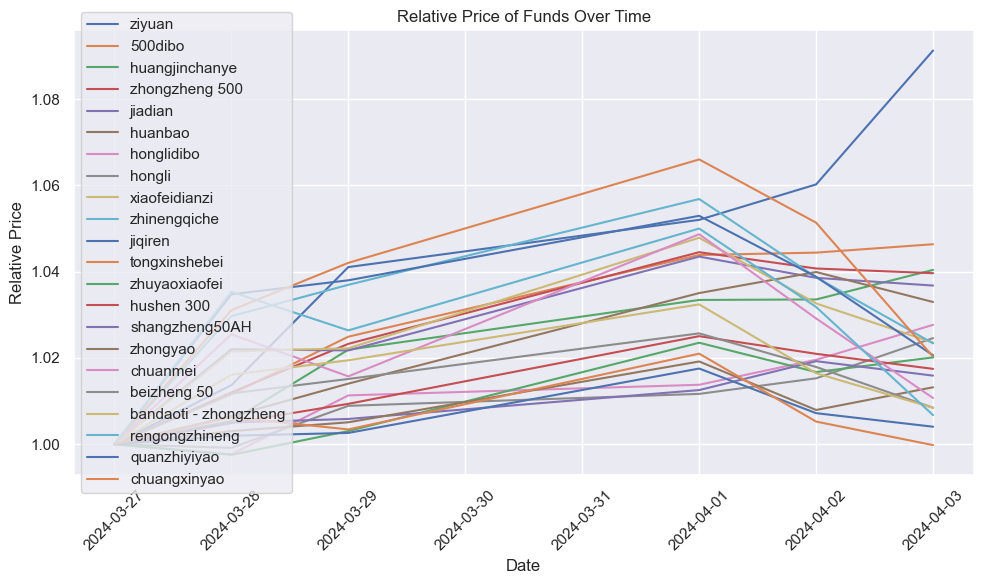

In [8]:
df_fund_sub = df_fund[df_fund['date']>='2024-03-27']
df_fund_sub['date'] = pd.to_datetime(df_fund_sub['date'])
base_nav = df_fund_sub[df_fund_sub['date'] == '2024-03-27'][['name', 'NAV']]

# Rename the 'stock_price' column to 'base_price'
base_nav.columns = ['name', 'base_NAV']

# Merge base_prices with the original DataFrame to get base prices for all dates
df_fund_sub = pd.merge(df_fund_sub, base_nav, on='name', how='left')

# Calculate the relative price ratio
df_fund_sub['relative_price'] = df_fund_sub['NAV'] / df_fund_sub['base_NAV']

# Assuming df contains the relative_price column and date column is already in datetime format
# Get a list of unique stock names

last_date = df_fund_sub['date'].max()
# Filter the DataFrame to get data only for the last date
last_date_data = df_fund_sub[df_fund_sub['date'] == last_date]
# Sort the data by relative_price in descending order
sorted_data = last_date_data.sort_values(by='relative_price', ascending=False)

# Get the sorted list of stock names
sorted_stock_names = sorted_data['name'].tolist()

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate through each stock and plot its relative price over time
for name in sorted_stock_names:
    fund_data = df_fund_sub[df_fund_sub['name'] == name]
    ax.plot(fund_data['date'], fund_data['relative_price'], label=name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Relative Price')
ax.set_title('Relative Price of Funds Over Time')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
ax.legend(loc='center left')

# Show plot
plt.tight_layout()
plt.show()

In [9]:
from kneed import KneeLocator
from sklearn.cluster import KMeans

def get_optimum_clusters(df, saturation_point=0.05):
    '''

    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    # knee = KneeLocator(range(1, size), wcss, curve='convex', direction='decreasing')
    # optimum_k = knee.knee

    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

def identify_weak_support_resistance(data):
    # Initialize an empty list to store the labels (support, resistance, neither)
    labels = []

    # Iterate through the dataframe to identify weak support and weak resistance
    for i in range(len(data)):
        if i == 0 or i == len(data) - 1:
            # Edge cases where there's no previous or following day
            labels.append("neither")
        elif data['NAV'][i] < data['NAV'][i - 1] and data['NAV'][i] < data['NAV'][i + 1]:
            # Weak support condition
            labels.append("weak support")
        elif data['NAV'][i] > data['NAV'][i - 1] and data['NAV'][i] > data['NAV'][i + 1]:
            # Weak resistance condition
            labels.append("weak resistance")
        else:
            # Neither weak support nor weak resistance
            labels.append("neither")

    # Add the labels to a new column in the dataframe
    data['Support/Resistance'] = labels

    return data

In [10]:
from dateutil.relativedelta import relativedelta
from math import ceil, floor

def stock_bollinger_move(stock_df, start=(datetime.today() - relativedelta(years=3)).strftime('%Y-%m-%d')):
    df = stock_df[stock_df['date'].between(start,datetime.today().strftime('%Y-%m-%d'))]
    df = df.sort_values(by='date').reset_index()

    if df['name'].unique()[0] == 'hongli':
        df['daily_price'] = df['NAV-Cum']
    else:
        df['daily_price'] = df['NAV']

    
    print(datetime.today().strftime('%Y-%m-%d'))
    print('* previous stock price closing', round(df.iloc[-1]['daily_price'],2))

    # Support and Resistance
    df = identify_weak_support_resistance(df)
    low_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak support'][['date',"daily_price"]].set_index('date'))
    low_centers = low_clusters.cluster_centers_
    low_centers = np.sort(low_centers, axis=0)
    
    high_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak resistance'][['date',"daily_price"]].set_index('date'))
    high_centers = high_clusters.cluster_centers_
    high_centers = np.sort(high_centers, axis=0)
    
    print(low_centers)
    print(high_centers)

    df['20 Day MA'] = df['daily_price'].rolling(window=20).mean()
    df['20 Day STD'] = df['daily_price'].rolling(window=20).std()
    
    # Calculate upper and lower bands
    df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    print("Latest Lower Bollinger Band:", df['Lower Band'].tolist()[-1])
    print("Latest Higher Bollinger Band:", df['Upper Band'].tolist()[-1])
    fig, ax = plt.subplots(figsize=(32,8))
    ax.grid(True, alpha=0.5)
    ax.set_title(stock_df['name'].unique()[0])
    ax.plot(df['date'], df['daily_price'], label='Daily Price')
    ax.plot(df['date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
    ax.plot(df['date'], df['Upper Band'], ls='--', label='Upper Bollinger Band')
    ax.plot(df['date'], df['Lower Band'], ls='--', label='Lower Bollinger Band')
    ax.fill_between(df['date'], df['Upper Band'], df['Lower Band'], color='gray', alpha=0.3) # Fill the area between the bands
    for low in low_centers[:]:
        ax.axhline(low[0], color='green', ls='--')
    
    for high in high_centers[:]:
        ax.axhline(high[0], color='red', ls='--')

zhongzheng 500
2024-04-04
* previous stock price closing 1.24
[[1.19286875]
 [1.29901579]
 [1.37181333]
 [1.4379175 ]
 [1.55024483]]
[[1.22888125]
 [1.31648889]
 [1.38827656]
 [1.45611892]
 [1.56567   ]]
Latest Lower Bollinger Band: 1.1963150616973341
Latest Higher Bollinger Band: 1.279914938302666


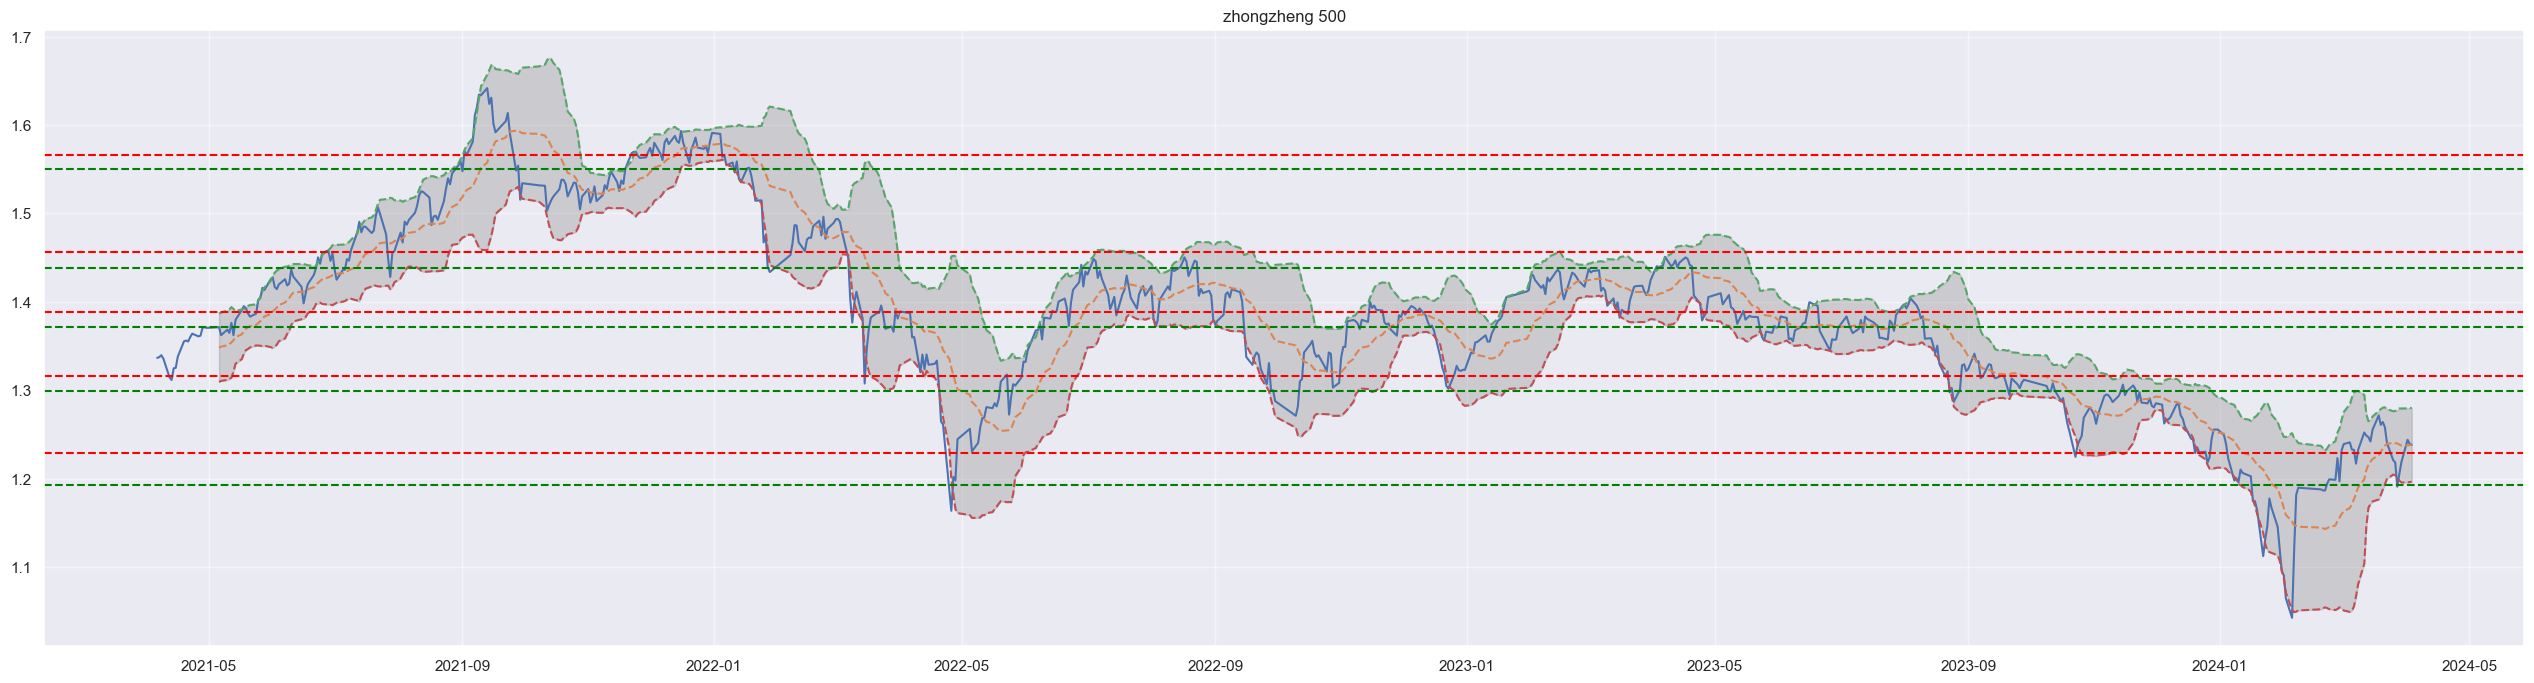

In [11]:
# solid buy 1.19
print(df_fund["name"].unique().tolist()[0])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[0]])

500dibo
2024-04-04
* previous stock price closing 1.34
[[1.21907895]
 [1.29224923]
 [1.37051429]
 [1.42164706]]
[[1.2912274 ]
 [1.3751451 ]
 [1.43223721]]
Latest Lower Bollinger Band: 1.2906950716207424
Latest Higher Bollinger Band: 1.3674149283792574


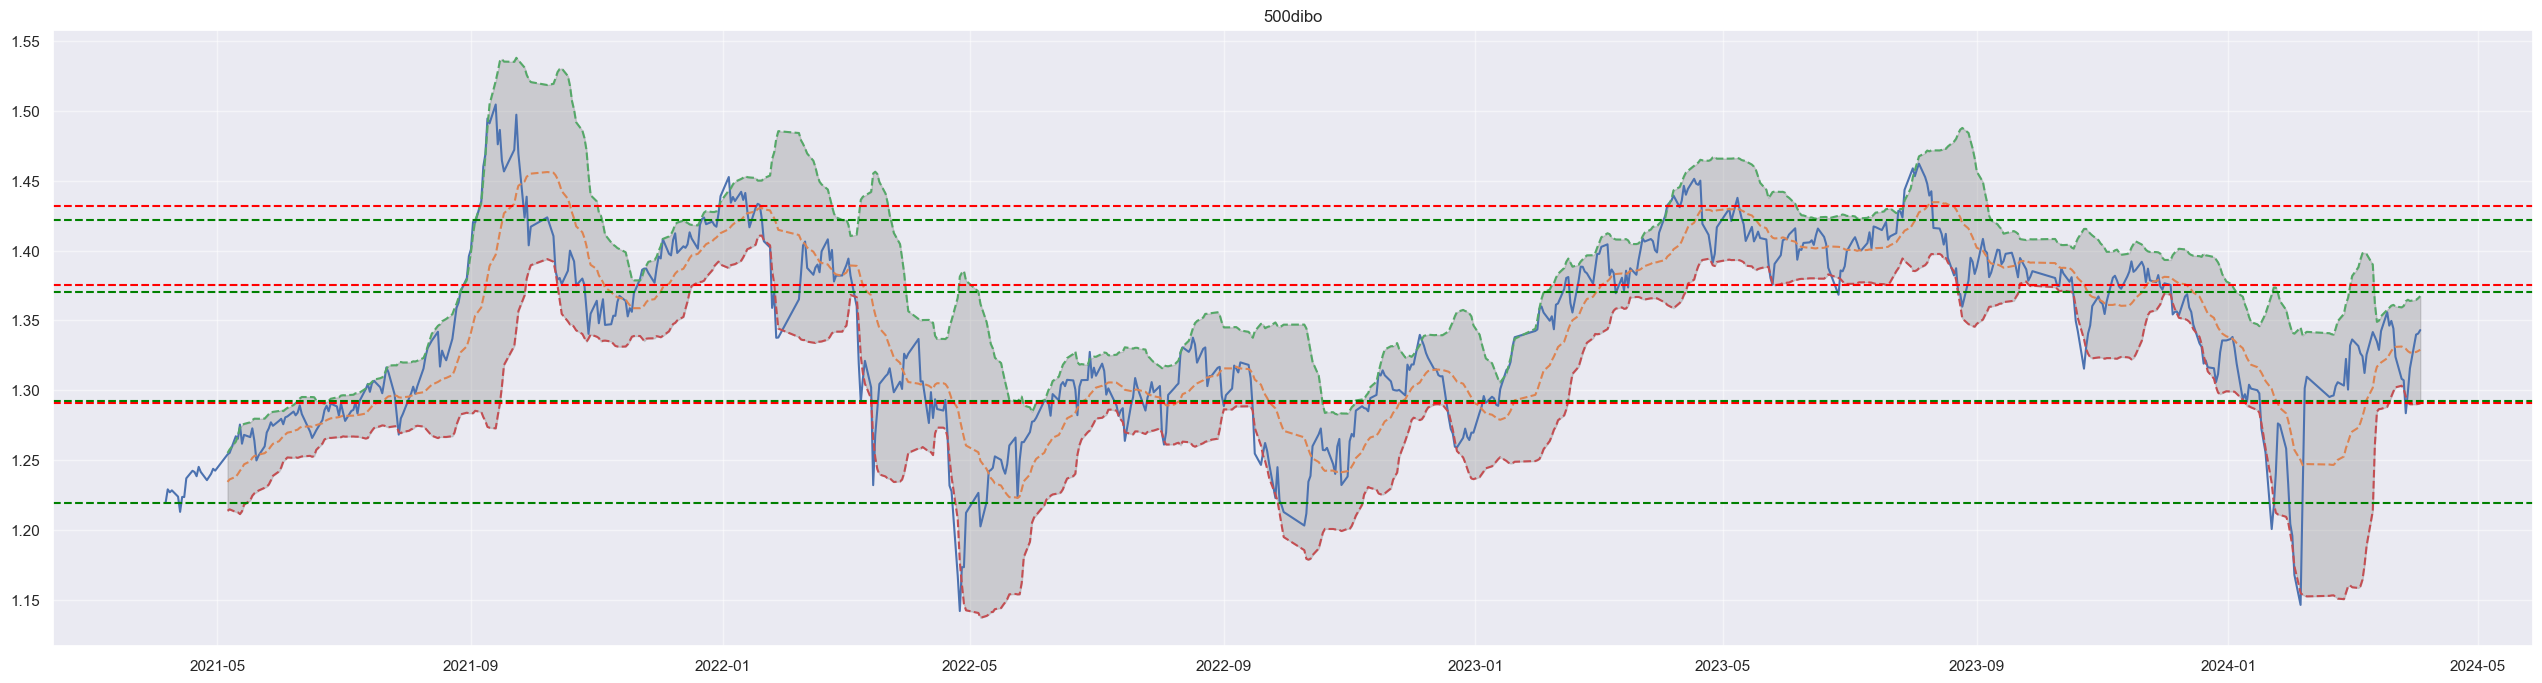

In [12]:
# solid buy 1.29
print(df_fund["name"].unique().tolist()[1])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[1]])

bandaoti - zhongzheng
2024-04-04
* previous stock price closing 1.41
[[1.2131    ]
 [1.42835   ]
 [1.60251905]
 [1.70725833]
 [1.82594419]
 [1.9491    ]
 [2.10092105]
 [2.31087857]
 [2.46918889]
 [2.61678   ]]
[[1.4348    ]
 [1.6573871 ]
 [1.758272  ]
 [1.85305128]
 [1.96374118]
 [2.13306316]
 [2.28287778]
 [2.46736842]
 [2.63062857]
 [2.82623333]]
Latest Lower Bollinger Band: 1.3877036977811044
Latest Higher Bollinger Band: 1.5566363022188952


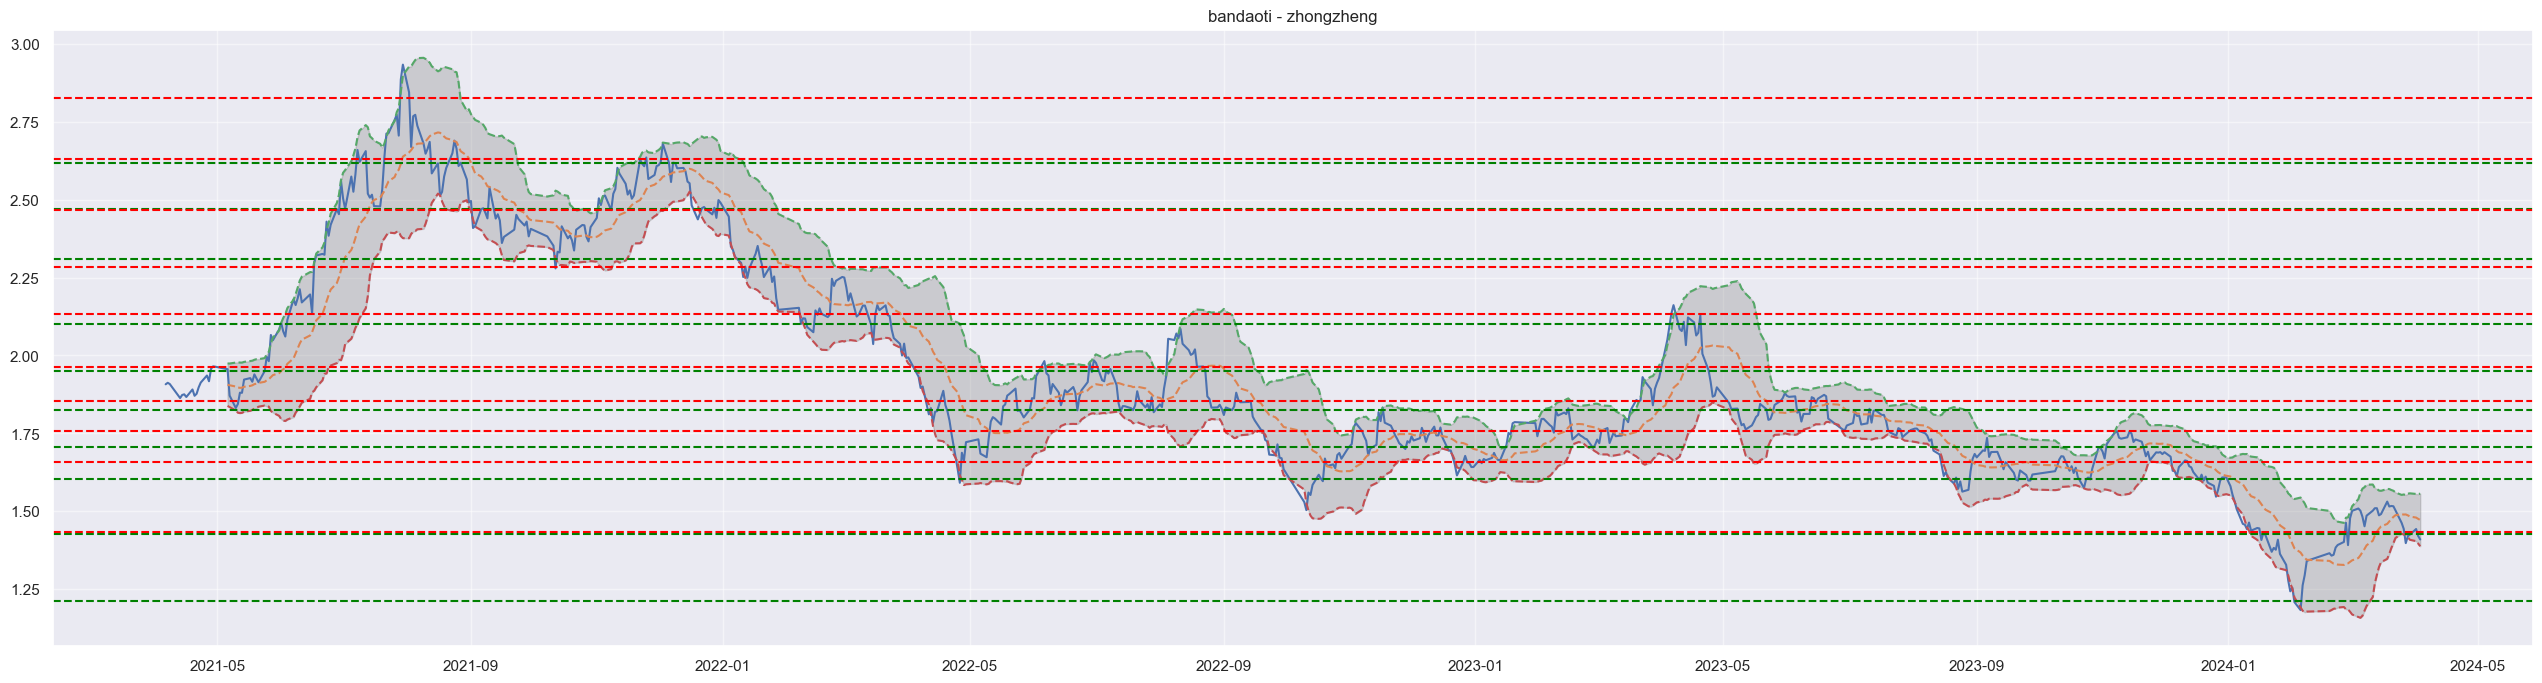

In [13]:
# down 0.07, up 0.25/0.3, multiplier 1.05
print(df_fund["name"].unique().tolist()[2])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[2]])

zhinengqiche
2024-04-04
* previous stock price closing 0.76
[[0.71707727]
 [0.79984545]
 [0.86971296]
 [0.95916333]
 [1.06809375]]
[[0.78306545]
 [0.87216571]
 [0.97442   ]
 [1.08904706]]
Latest Lower Bollinger Band: 0.7385013699241054
Latest Higher Bollinger Band: 0.8069786300758945


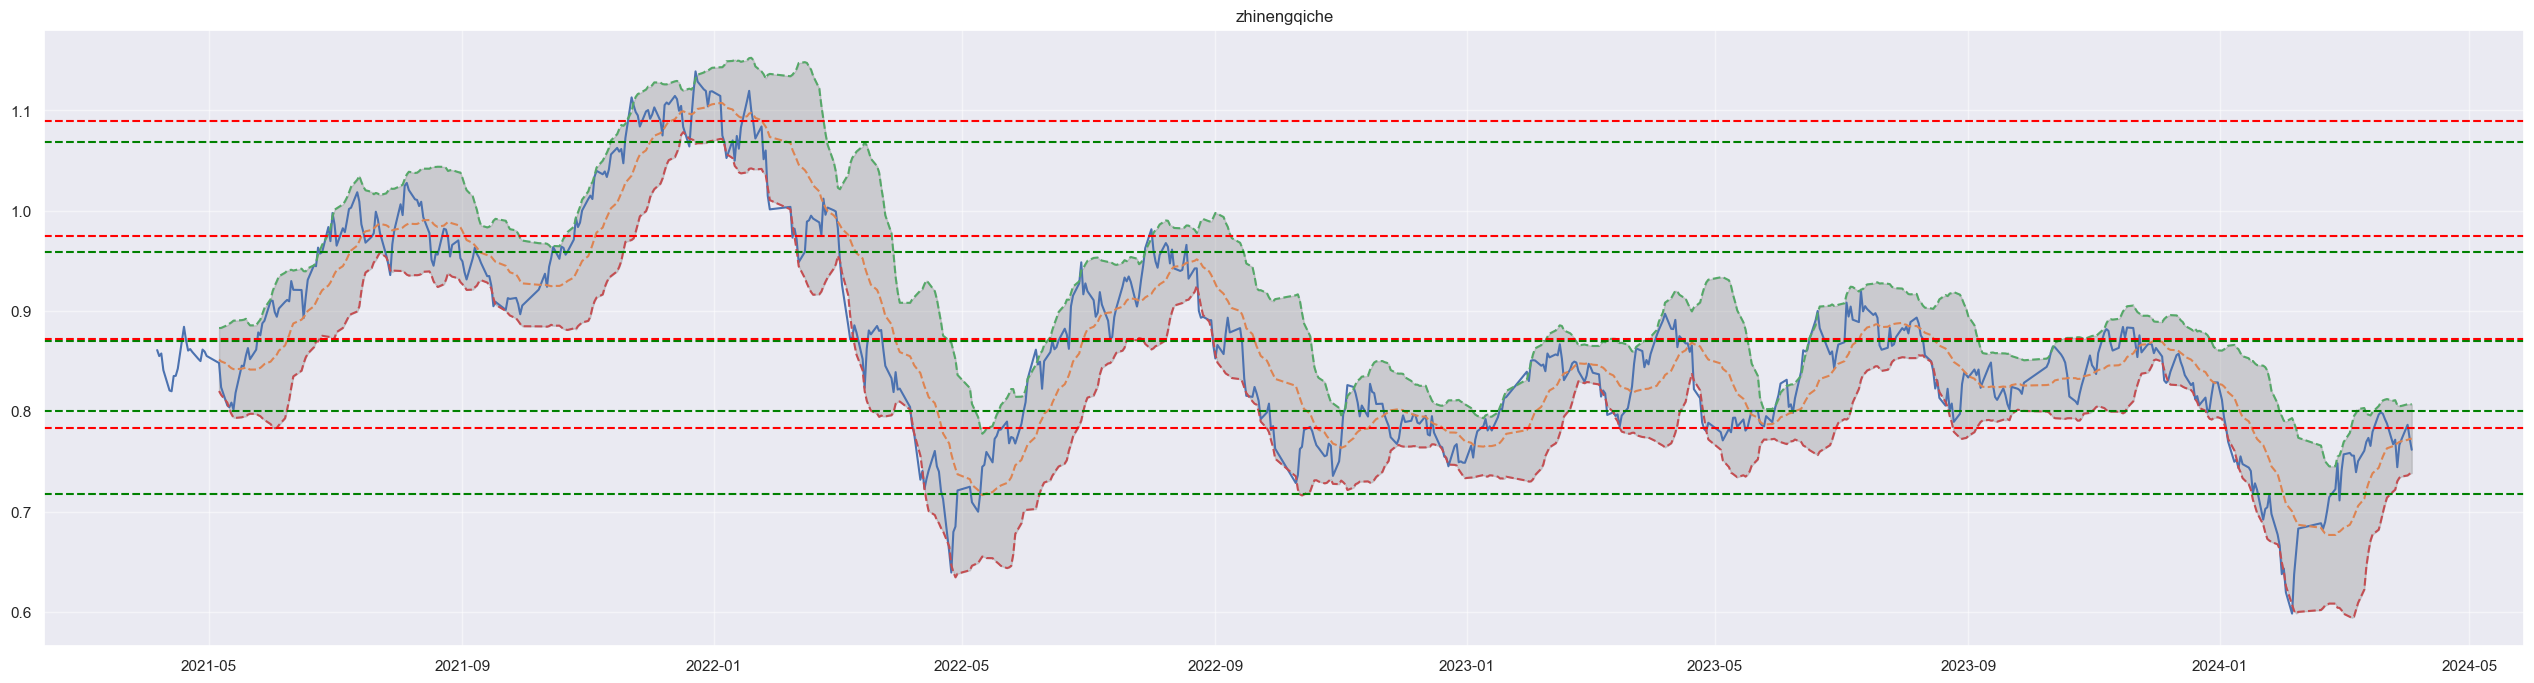

In [14]:
# sell 0.8
print(df_fund["name"].unique().tolist()[3])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[3]])

huanbao
2024-04-04
* previous stock price closing 0.7
[[0.678924  ]
 [0.7636    ]
 [0.89204   ]
 [1.01795937]
 [1.12090357]
 [1.2303    ]
 [1.32263077]]
[[0.71487027]
 [0.89759474]
 [1.03629487]
 [1.16006154]
 [1.26206552]
 [1.34730714]]
Latest Lower Bollinger Band: 0.6722219246579904
Latest Higher Bollinger Band: 0.7240480753420095


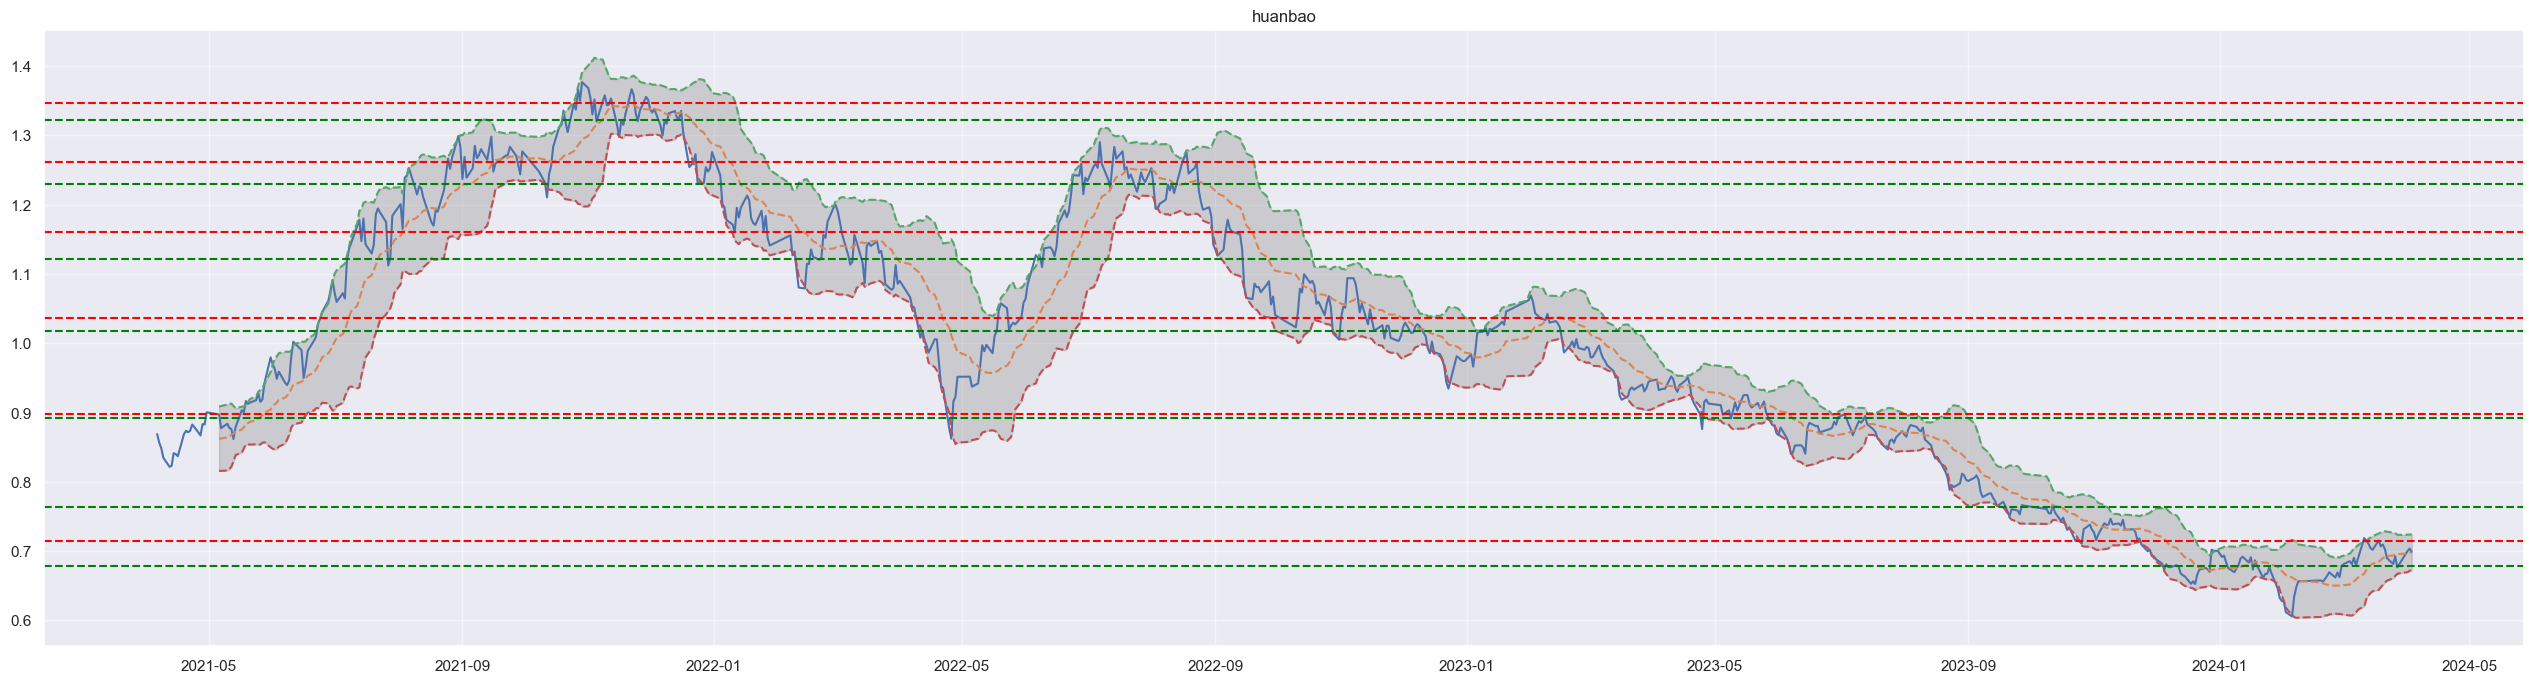

In [15]:
# solid buy at 0.67; sell between 0.715 - 0.72
print(df_fund["name"].unique().tolist()[4])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[4]])

jiqiren
2024-04-04
* previous stock price closing 0.88
[[0.80898889]
 [0.92596111]
 [1.01905   ]]
[[0.8223    ]
 [0.94628182]
 [1.04029   ]]
Latest Lower Bollinger Band: 0.8687222016378018
Latest Higher Bollinger Band: 0.9580577983621983


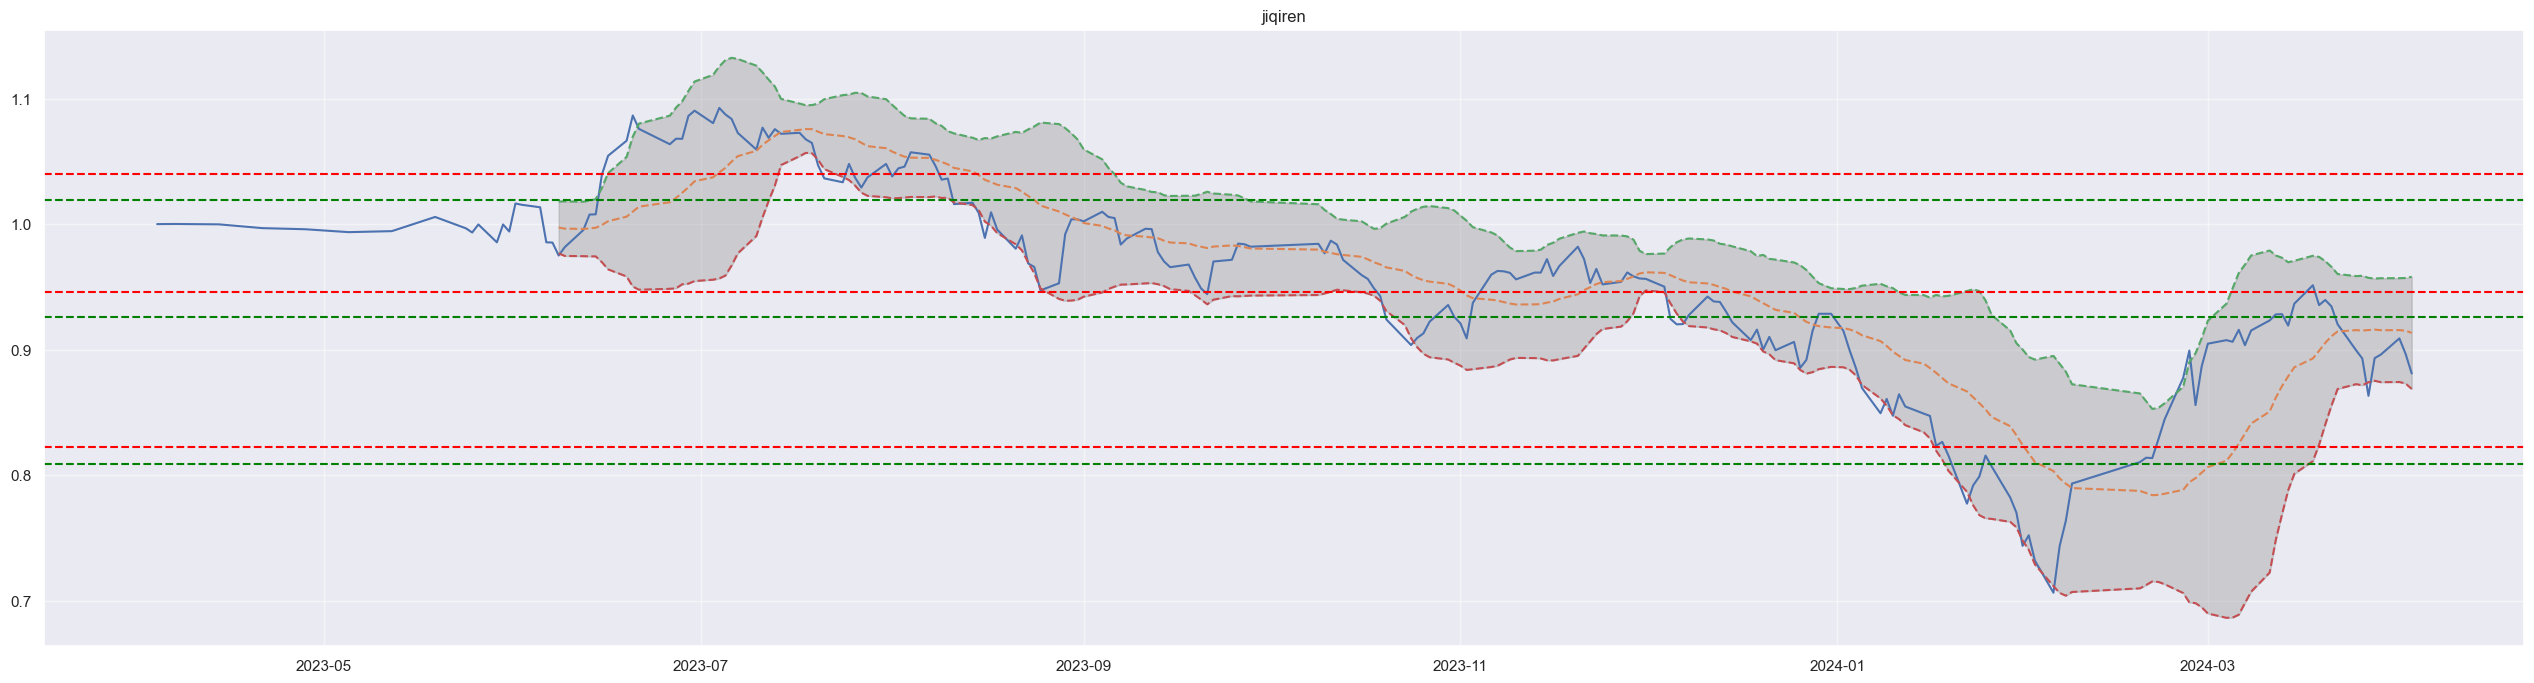

In [16]:
# try buy 0.868
print(df_fund["name"].unique().tolist()[5])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[5]])

xiaofeidianzi
2024-04-04
* previous stock price closing 0.7
[[0.70372188]
 [0.77454576]
 [0.86287778]]
[[0.73260732]
 [0.80117407]
 [0.89076957]]
Latest Lower Bollinger Band: 0.6854745172402714
Latest Higher Bollinger Band: 0.7453854827597286


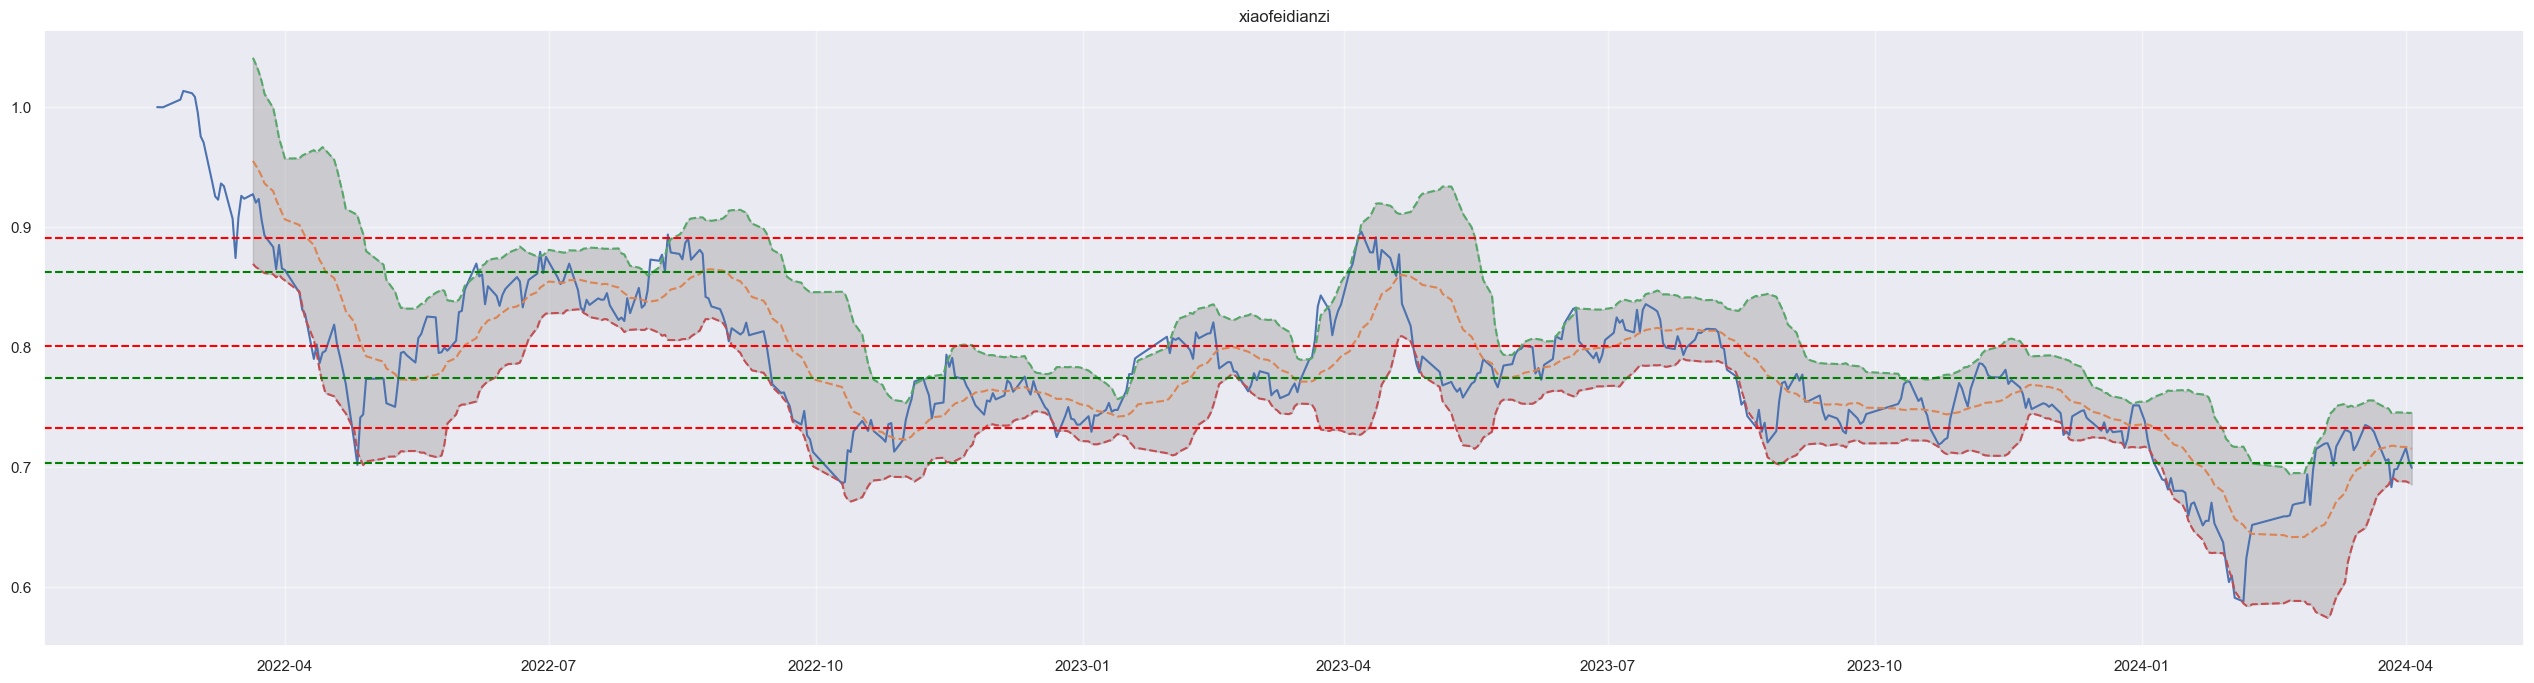

In [17]:
# try buy 0.685; zhifubao jijin 0.93
print(df_fund["name"].unique().tolist()[6])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[6]])

rengongzhineng
2024-04-04
* previous stock price closing 0.69
[[0.64802368]
 [0.71957561]
 [0.79468214]
 [0.8999303 ]
 [0.98540952]]
[[0.66611818]
 [0.73590222]
 [0.81126667]
 [0.92540526]
 [1.00800526]]
Latest Lower Bollinger Band: 0.6817325775066017
Latest Higher Bollinger Band: 0.7624174224933984


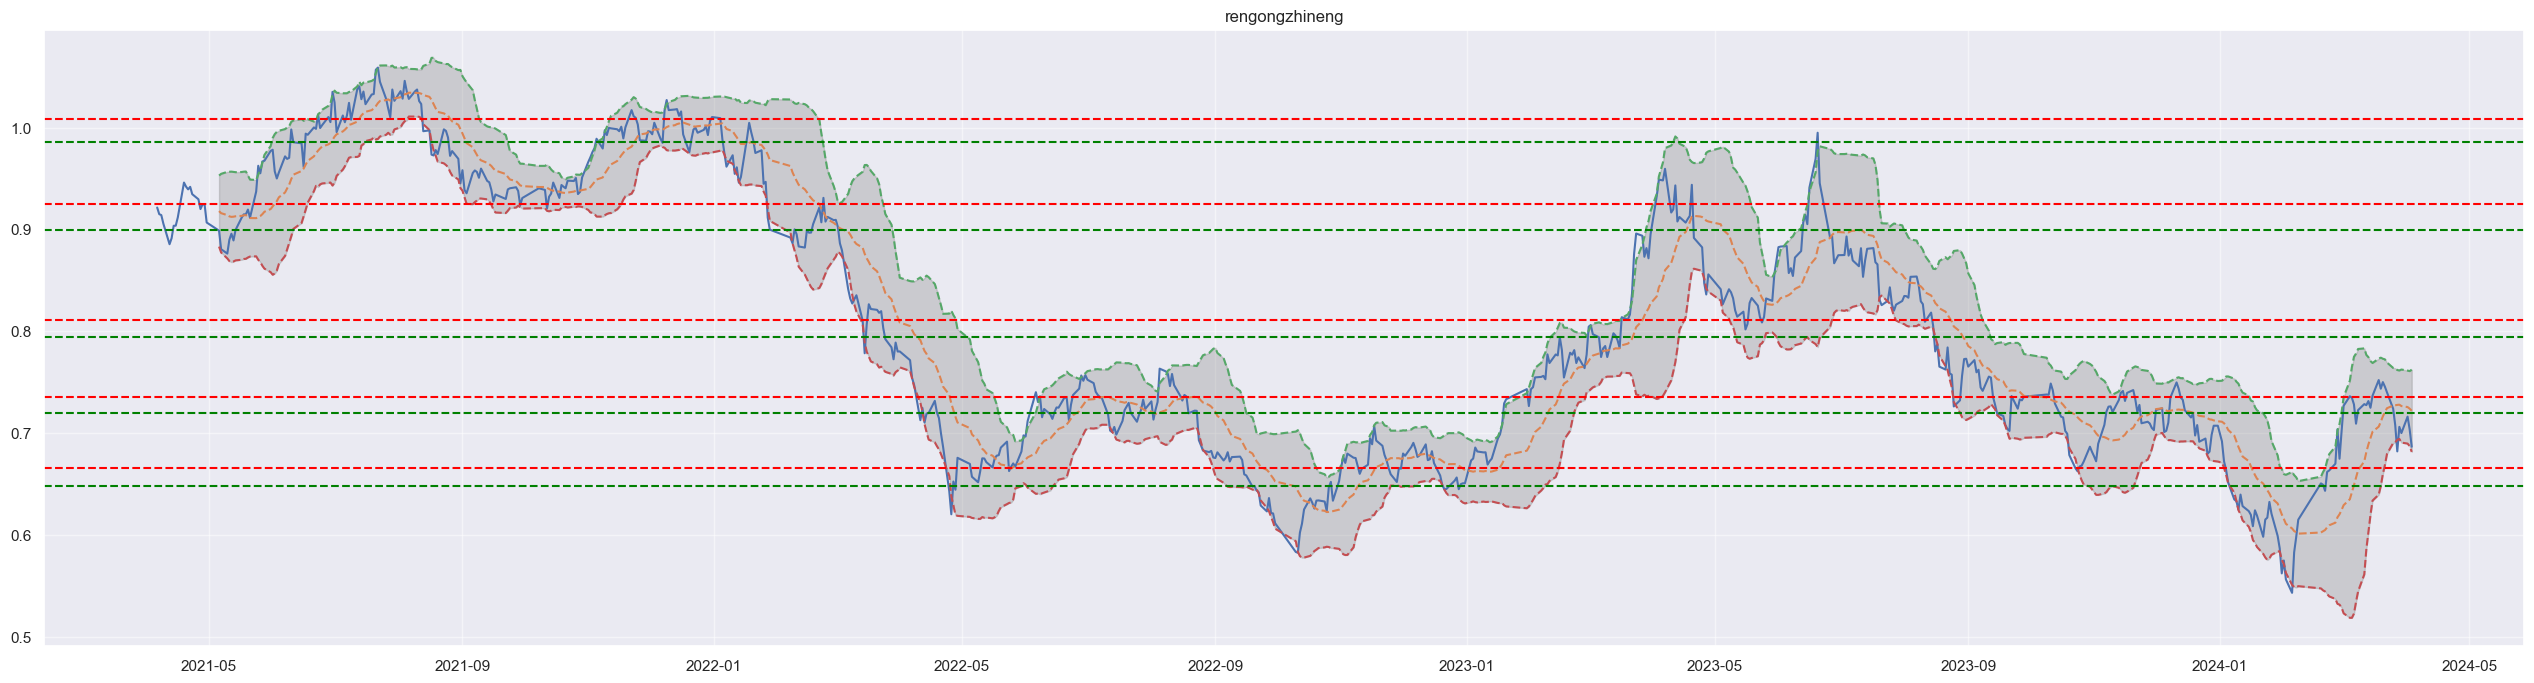

In [18]:
# try buy at 0.681 (zhifubao jijin: 0.86)
print(df_fund["name"].unique().tolist()[7])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[7]])

hushen 300
2024-04-04
* previous stock price closing 1.37
[[1.26739167]
 [1.36871111]
 [1.45030465]
 [1.5316    ]
 [1.64495556]
 [1.75378919]
 [1.825785  ]]
[[1.28116   ]
 [1.38481111]
 [1.4692619 ]
 [1.5502    ]
 [1.67347   ]
 [1.77683824]
 [1.84596667]]
Latest Lower Bollinger Band: 1.346173734158236
Latest Higher Bollinger Band: 1.3879362658417642


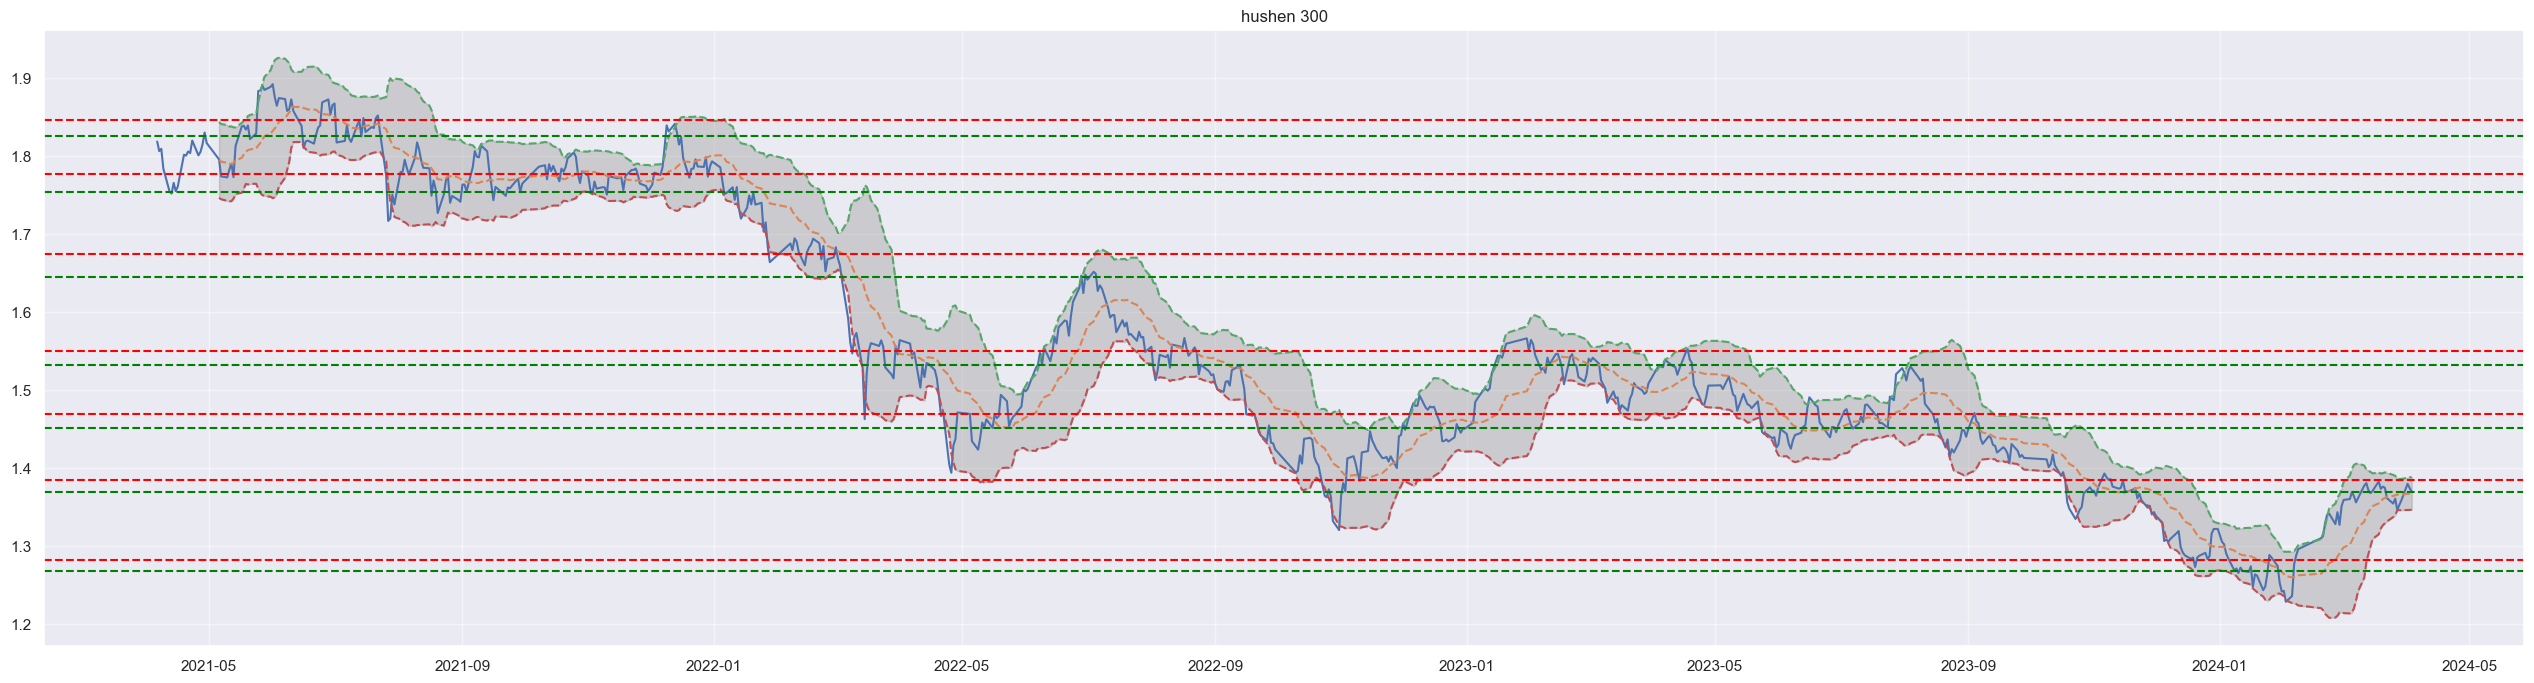

In [19]:
# 1.385 sell

print(df_fund["name"].unique().tolist()[8])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[8]])

zhuyaoxiaofei
2024-04-04
* previous stock price closing 2.37
[[2.16488182]
 [2.32139375]
 [2.474944  ]
 [2.61815625]
 [2.71881111]
 [2.81020455]
 [2.93773684]
 [3.086     ]
 [3.24642941]
 [3.45328333]]
[[2.19425   ]
 [2.36942778]
 [2.51937143]
 [2.67737727]
 [2.79692187]
 [2.91546   ]
 [3.04636111]
 [3.16408667]
 [3.30572308]
 [3.4766375 ]]
Latest Lower Bollinger Band: 2.2719777177372023
Latest Higher Bollinger Band: 2.4091222822627976


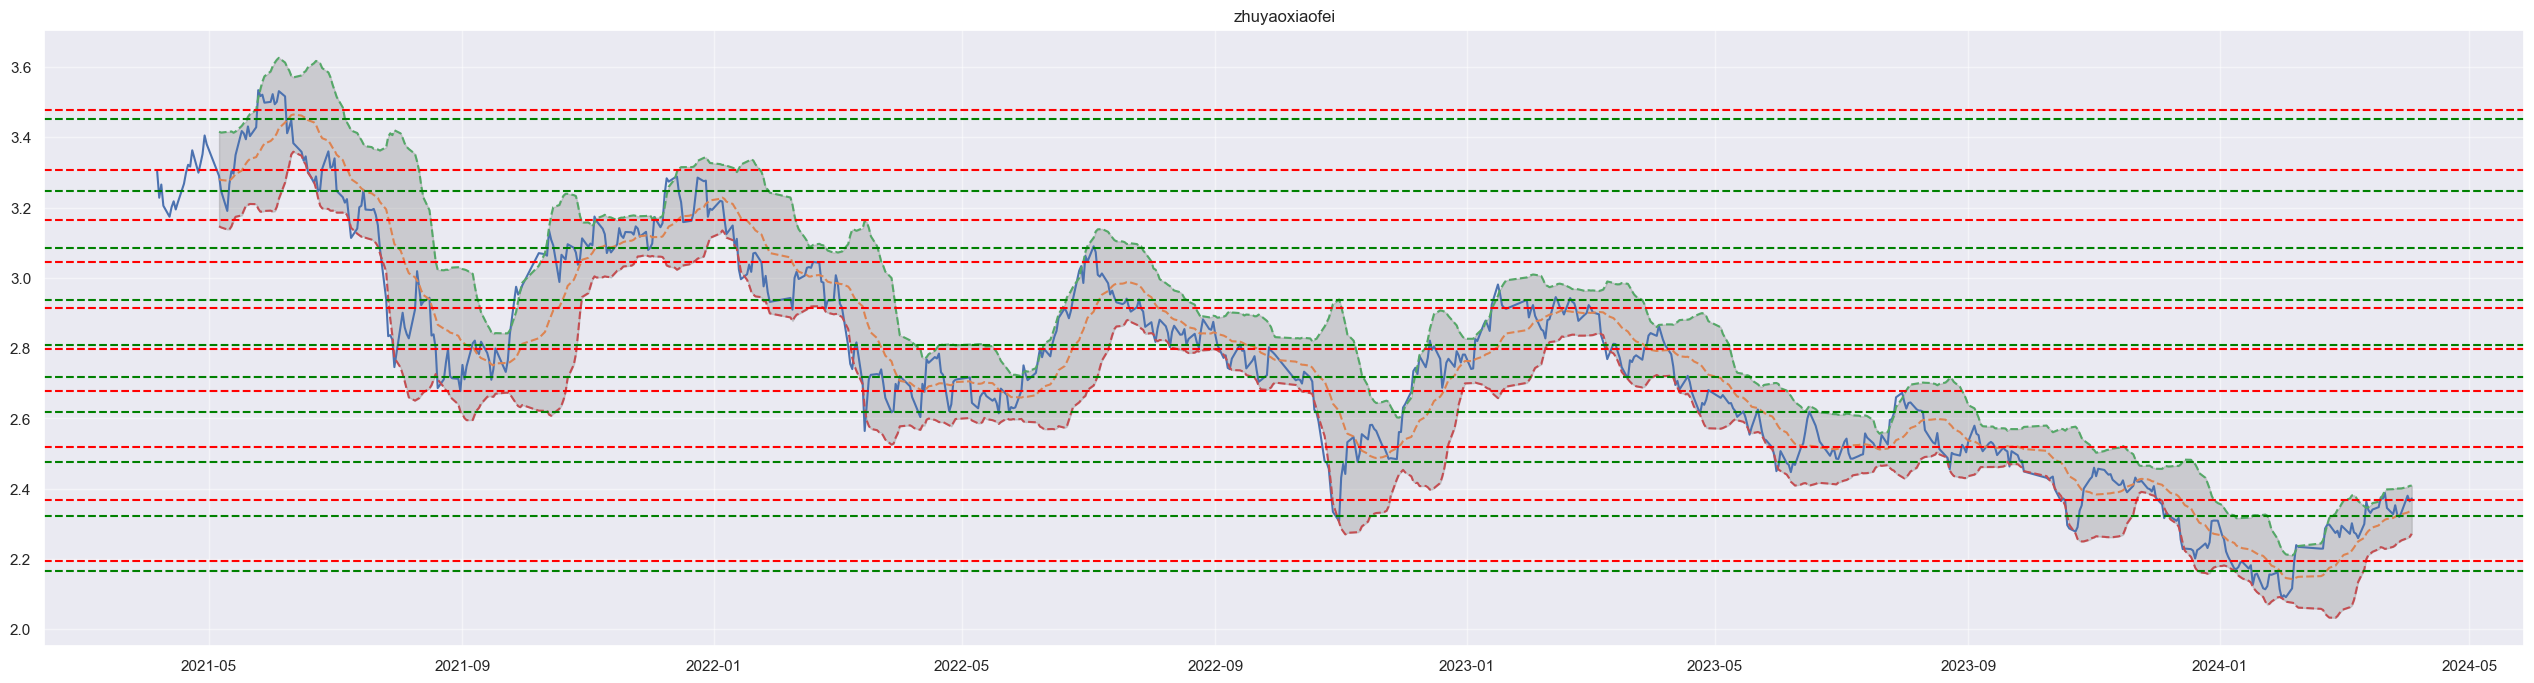

In [20]:
# Target sell: 2.37; buy: 2.26 - 2.29
print(df_fund["name"].unique().tolist()[10])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[10]])

jiadian
2024-04-04
* previous stock price closing 1.22
[[1.05838571]
 [1.13673478]
 [1.19130213]
 [1.2865871 ]
 [1.43851818]]
[[1.08578919]
 [1.16280192]
 [1.21657273]
 [1.31241923]
 [1.45494167]]
Latest Lower Bollinger Band: 1.1728754109198245
Latest Higher Bollinger Band: 1.2332145890801753


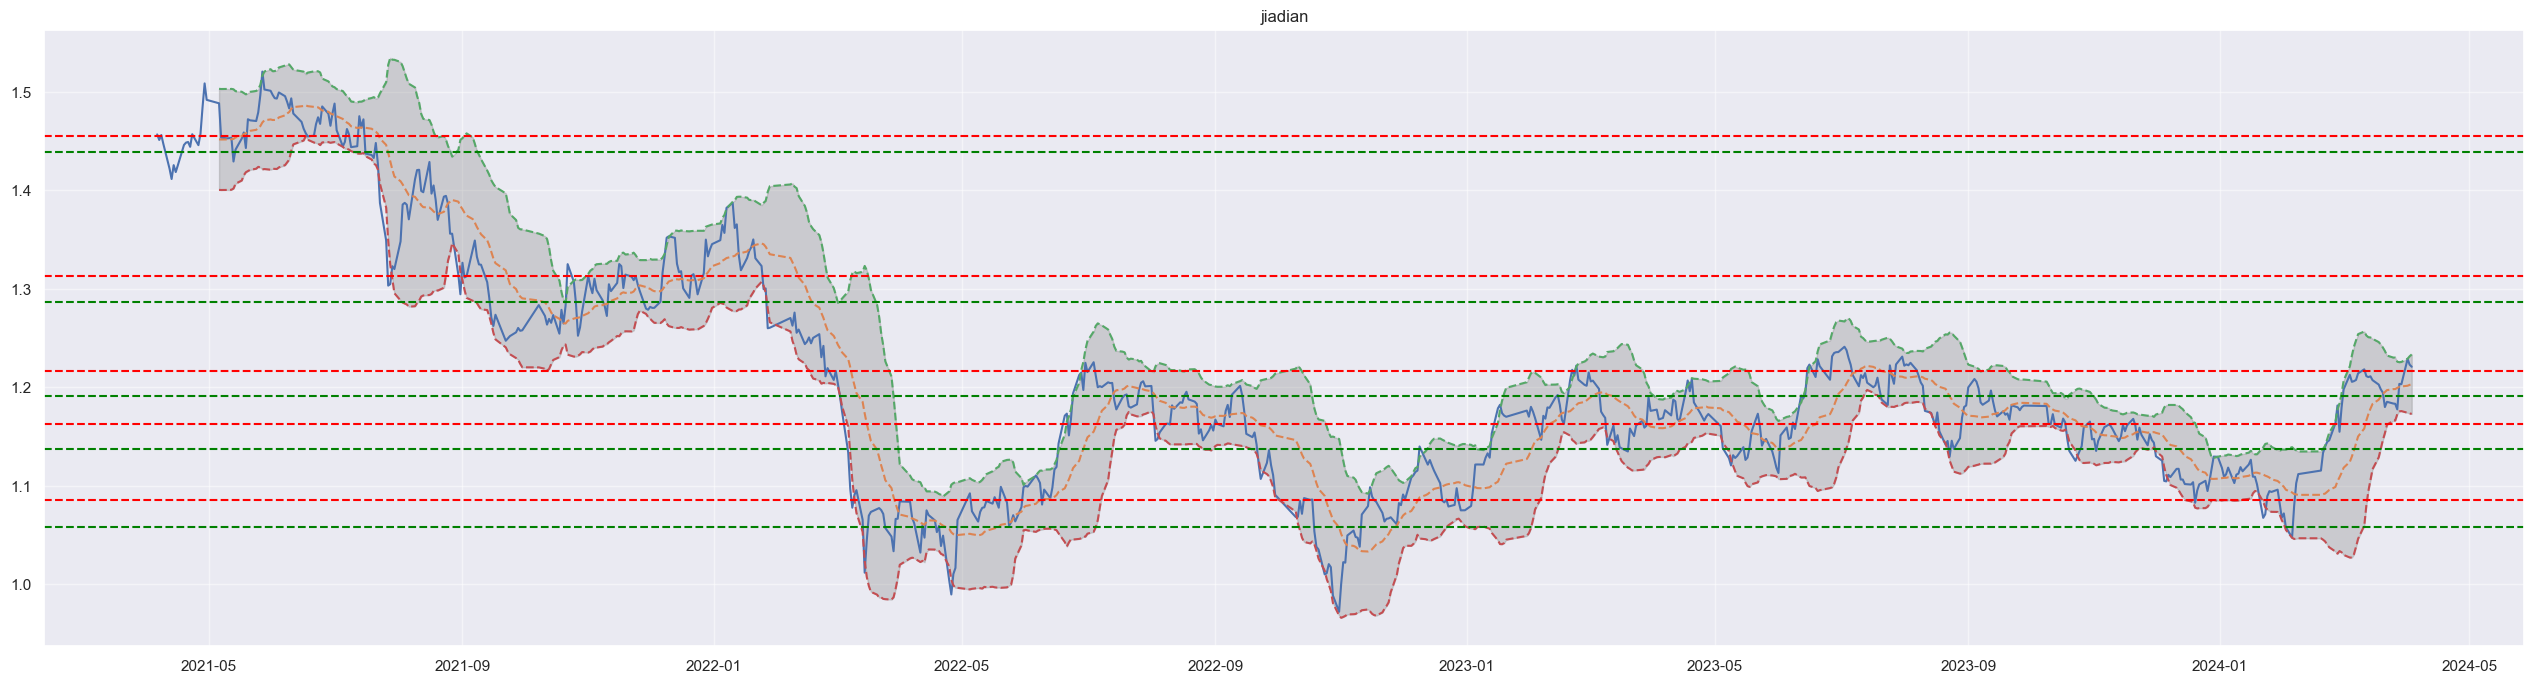

In [21]:
# Target sell: 1.23
# 1.05 solid buy
print(df_fund["name"].unique().tolist()[11])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[11]])

quanzhiyiyao
2024-04-04
* previous stock price closing 0.77
[[0.78782632]
 [0.8698775 ]
 [0.94747692]
 [1.00774211]
 [1.17166562]
 [1.31692941]]
[[0.80033889]
 [0.88277895]
 [0.96347209]
 [1.02800526]
 [1.19260312]
 [1.35554706]]
Latest Lower Bollinger Band: 0.751835584824403
Latest Higher Bollinger Band: 0.8189244151755971


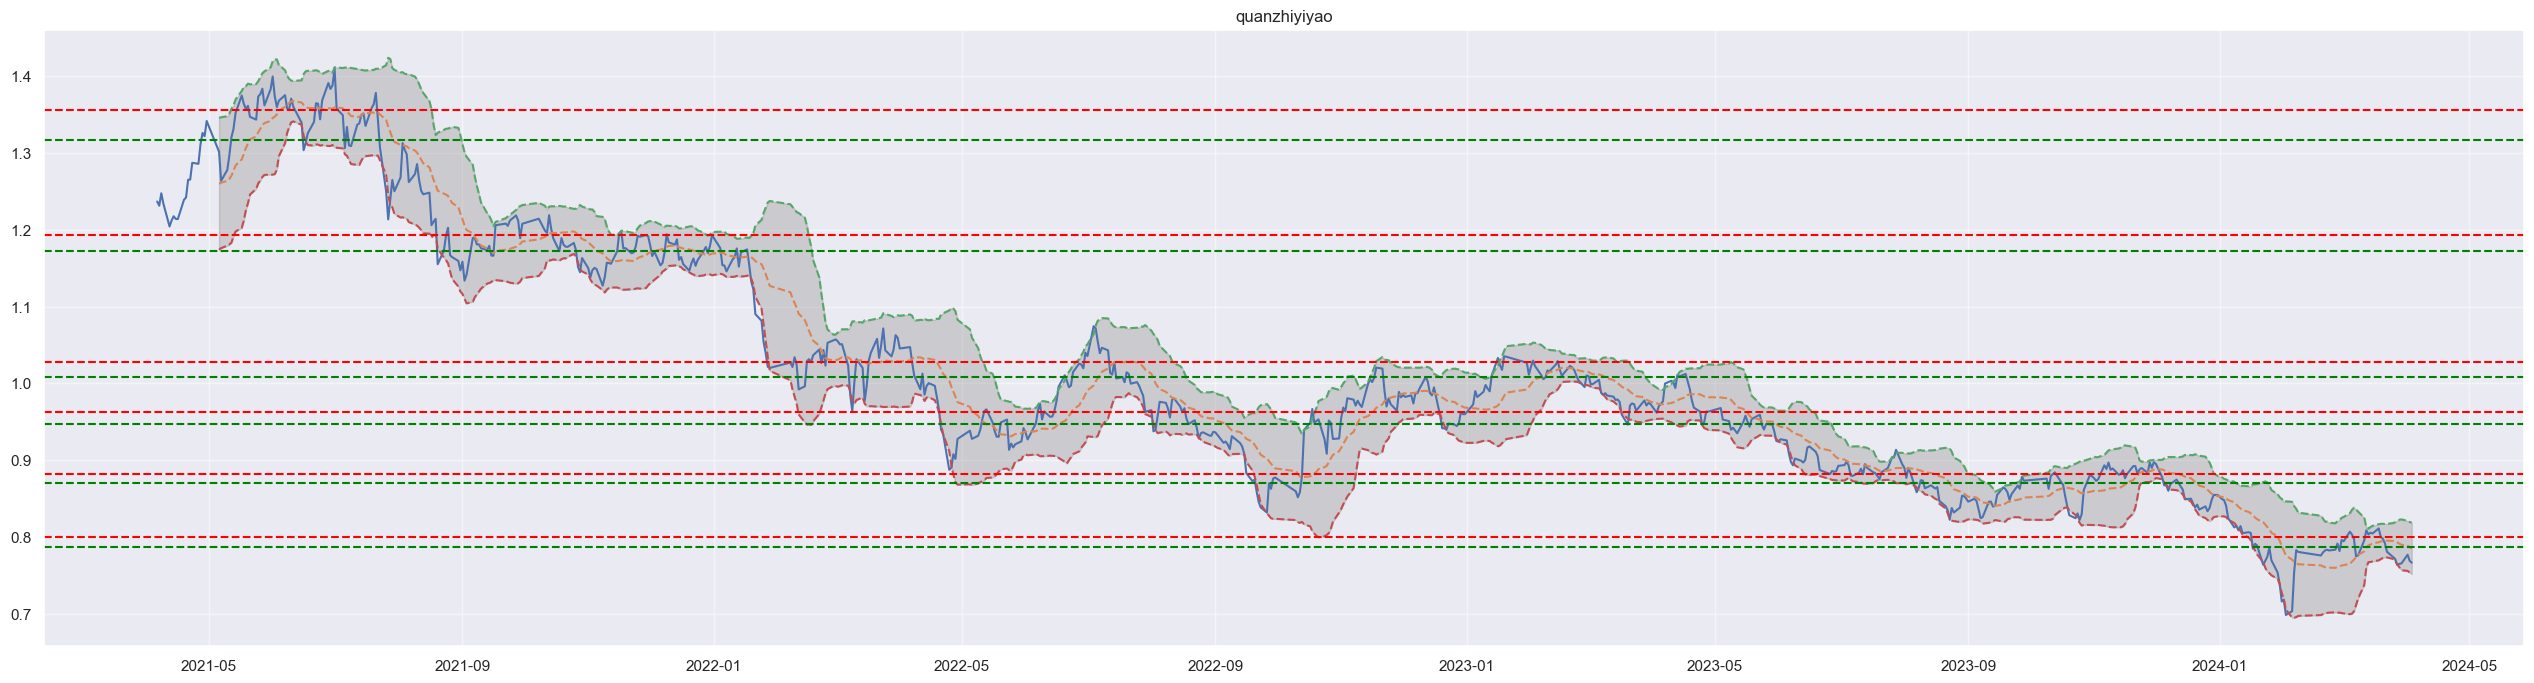

In [22]:
# buy 0.75
print(df_fund["name"].unique().tolist()[14])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[14]])

chuangxinyao
2024-04-04
* previous stock price closing 0.5
[[0.49918333]
 [0.57478529]
 [0.644006  ]
 [0.71413103]
 [0.8990871 ]]
[[0.5644881 ]
 [0.65590189]
 [0.73271   ]
 [0.90345926]
 [1.01948   ]]
Latest Lower Bollinger Band: 0.48458526278721725
Latest Higher Bollinger Band: 0.5376347372127829


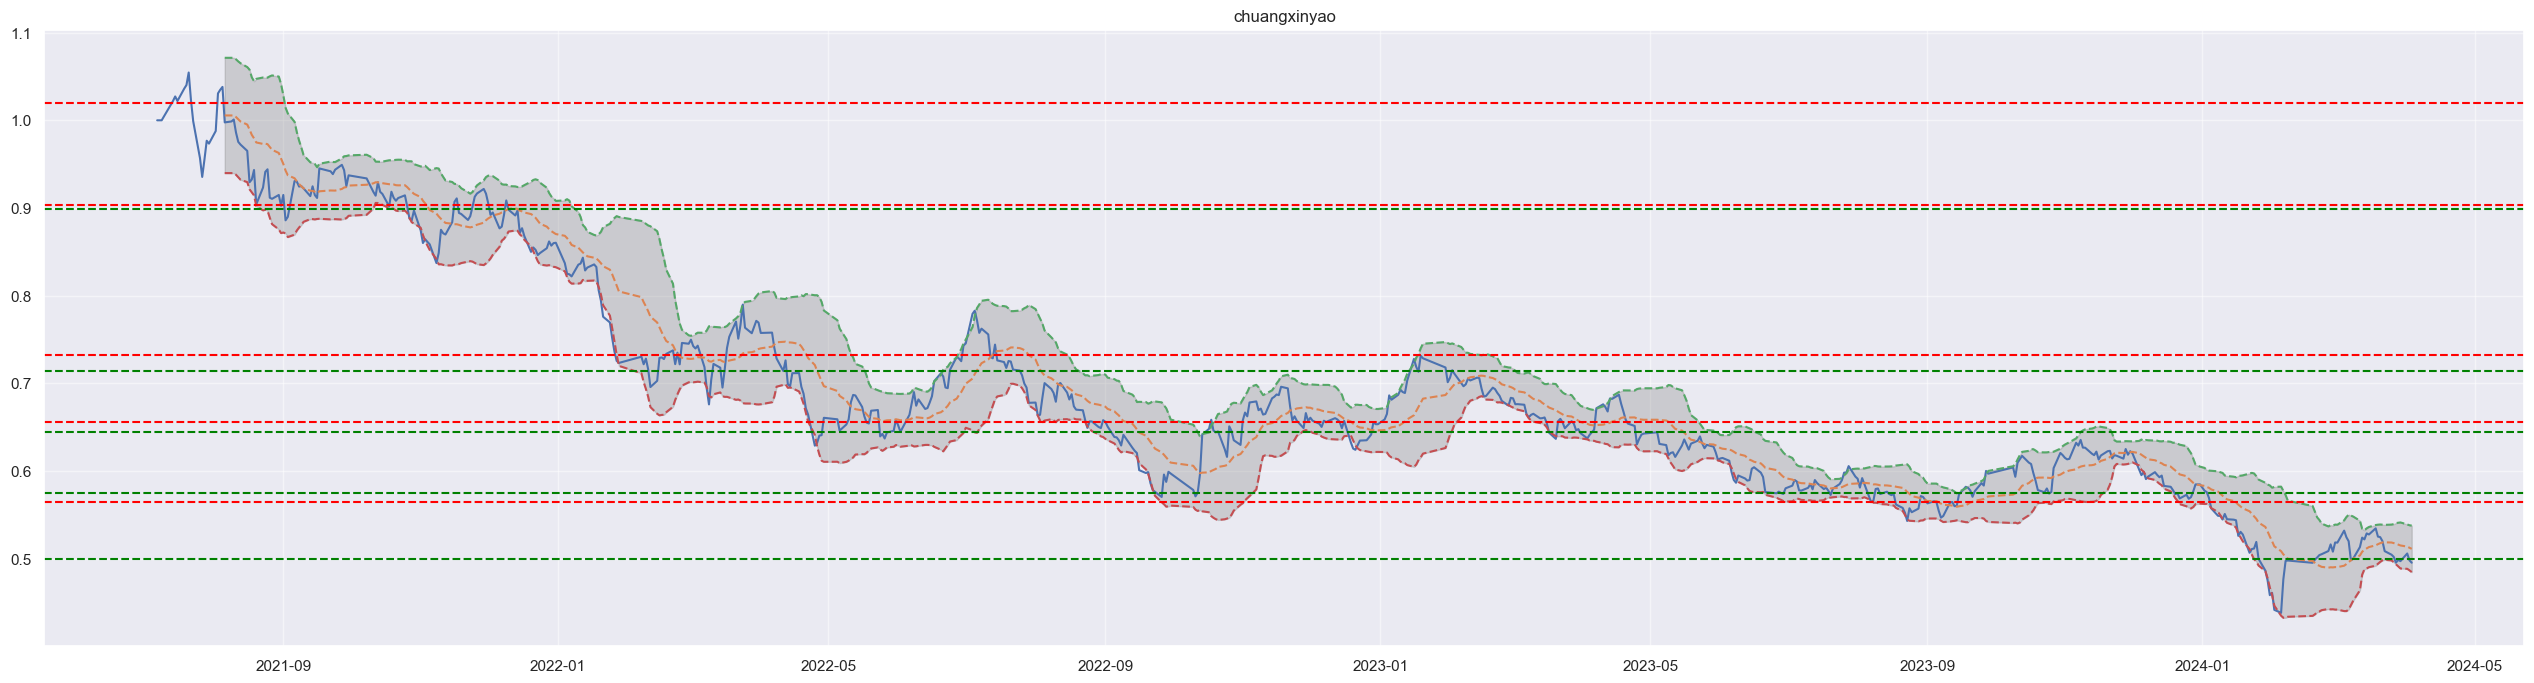

In [23]:
# buy 0.49 - zhifubao jijin 0.808
print(df_fund["name"].unique().tolist()[15])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[15]])

zhongyao
2024-04-04
* previous stock price closing 1.14
[[0.995925  ]
 [1.06975769]
 [1.15307586]
 [1.23052973]
 [1.30740476]]
[[1.01103333]
 [1.08983393]
 [1.17494259]
 [1.24353143]
 [1.32676429]]
Latest Lower Bollinger Band: 1.1093644815135268
Latest Higher Bollinger Band: 1.171245518486473


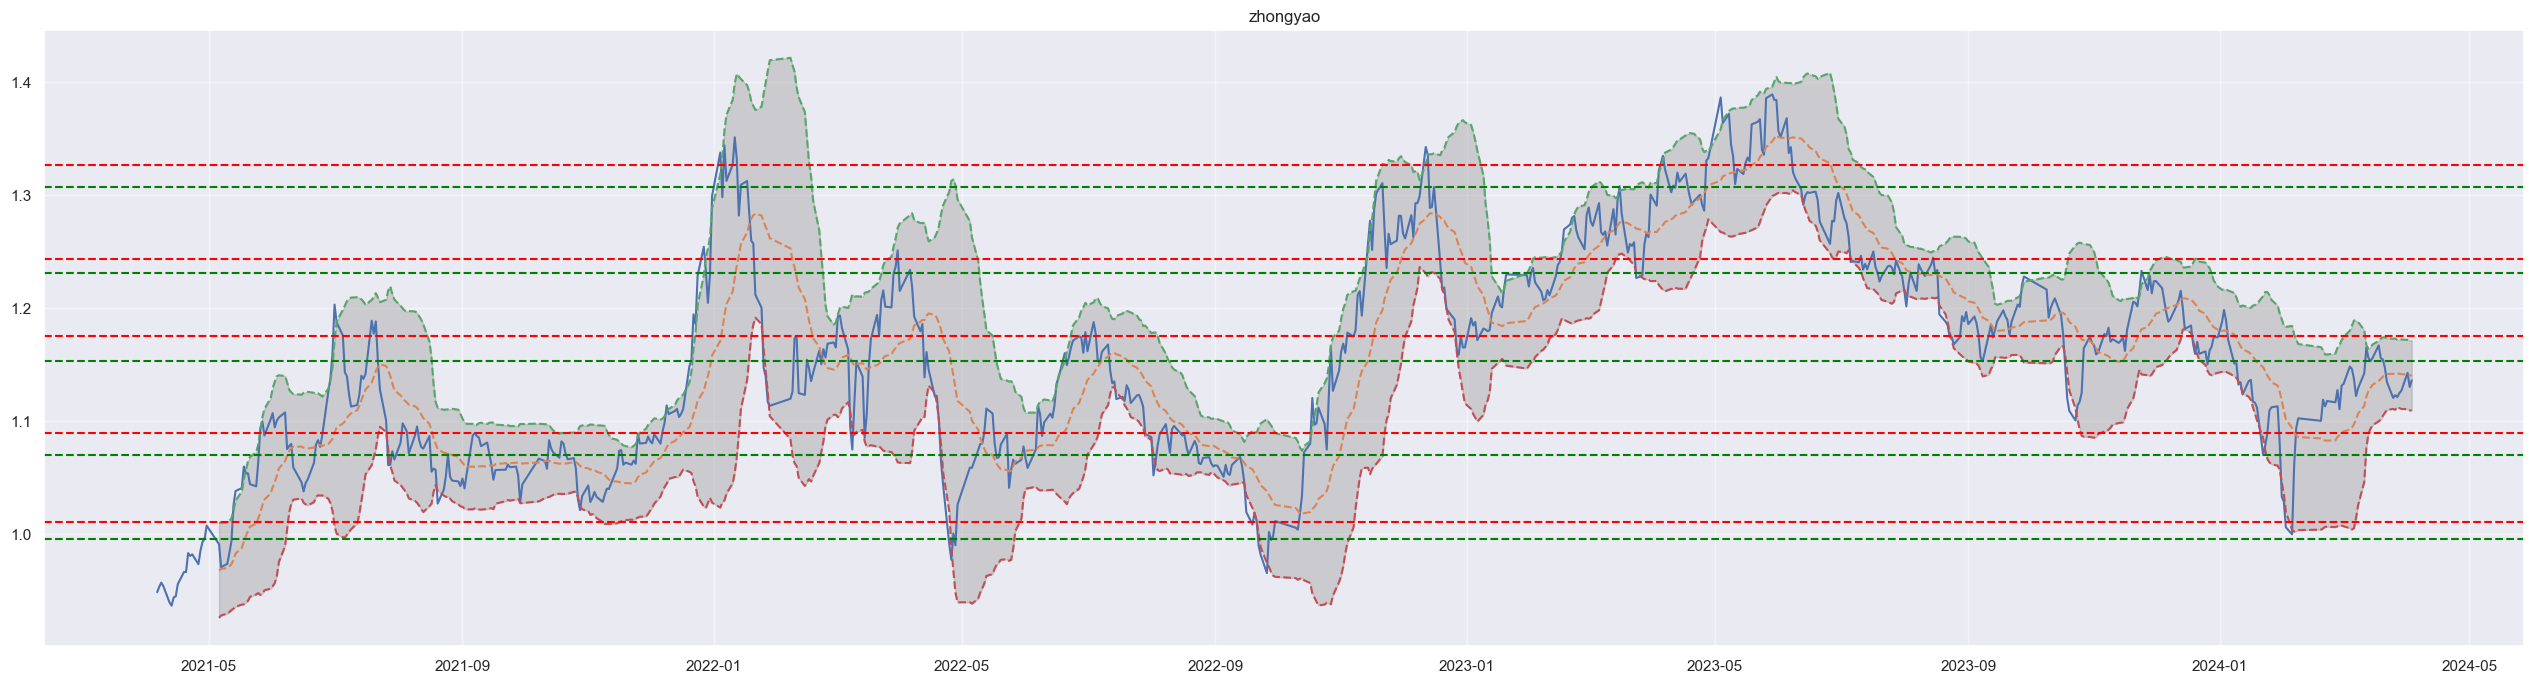

In [24]:
# sell at 0.9 --- for the selected zhifubao fund (not this one; this one 1.17)
print(df_fund["name"].unique().tolist()[16])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[16]])

chuanmei
2024-04-04
* previous stock price closing 0.75
[[0.60020588]
 [0.70192963]
 [0.79839483]
 [0.89110526]]
[[0.61396458]
 [0.715056  ]
 [0.81375077]
 [0.93233889]]
Latest Lower Bollinger Band: 0.7191207082518988
Latest Higher Bollinger Band: 0.8109992917481011


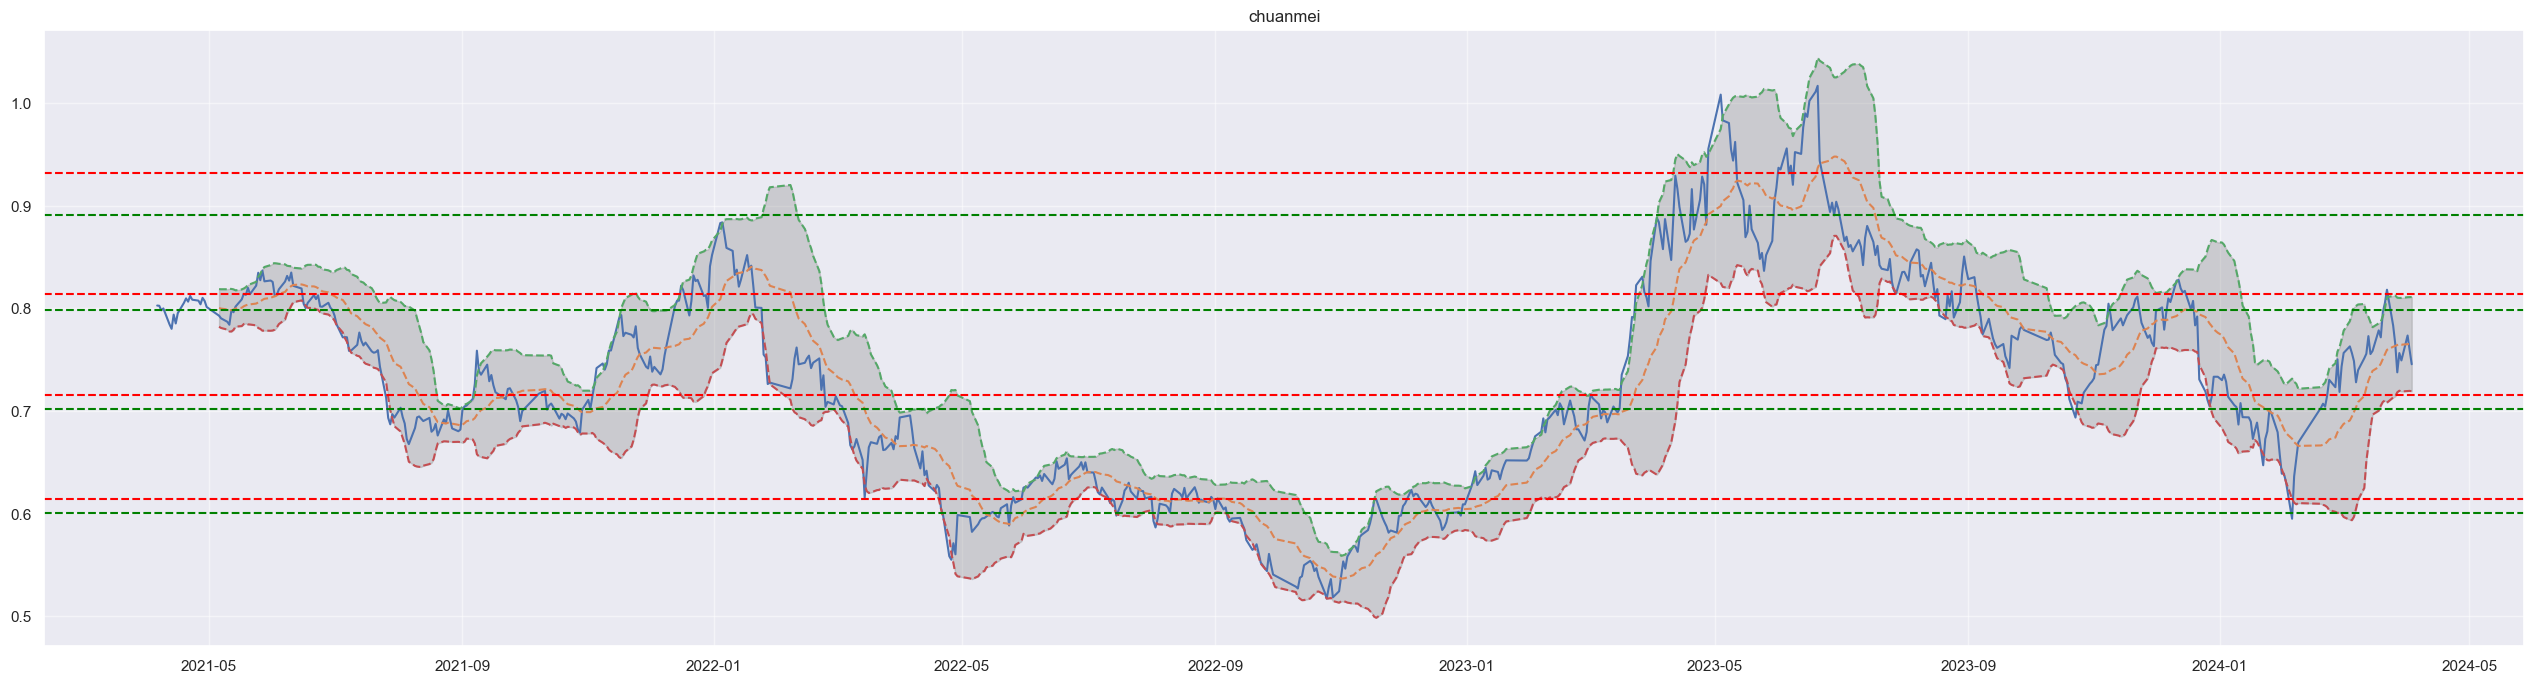

In [25]:
# sell 0.81, buy 0.736; solid buy 0.6
print(df_fund["name"].unique().tolist()[21])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[21]])

ziyuan
2024-04-04
* previous stock price closing 1.2
[[1.02761404]
 [1.10262353]
 [1.198125  ]]
[[1.0472963 ]
 [1.11357576]
 [1.1725    ]
 [1.3196    ]]
Latest Lower Bollinger Band: 1.0818178524344733
Latest Higher Bollinger Band: 1.173782147565527


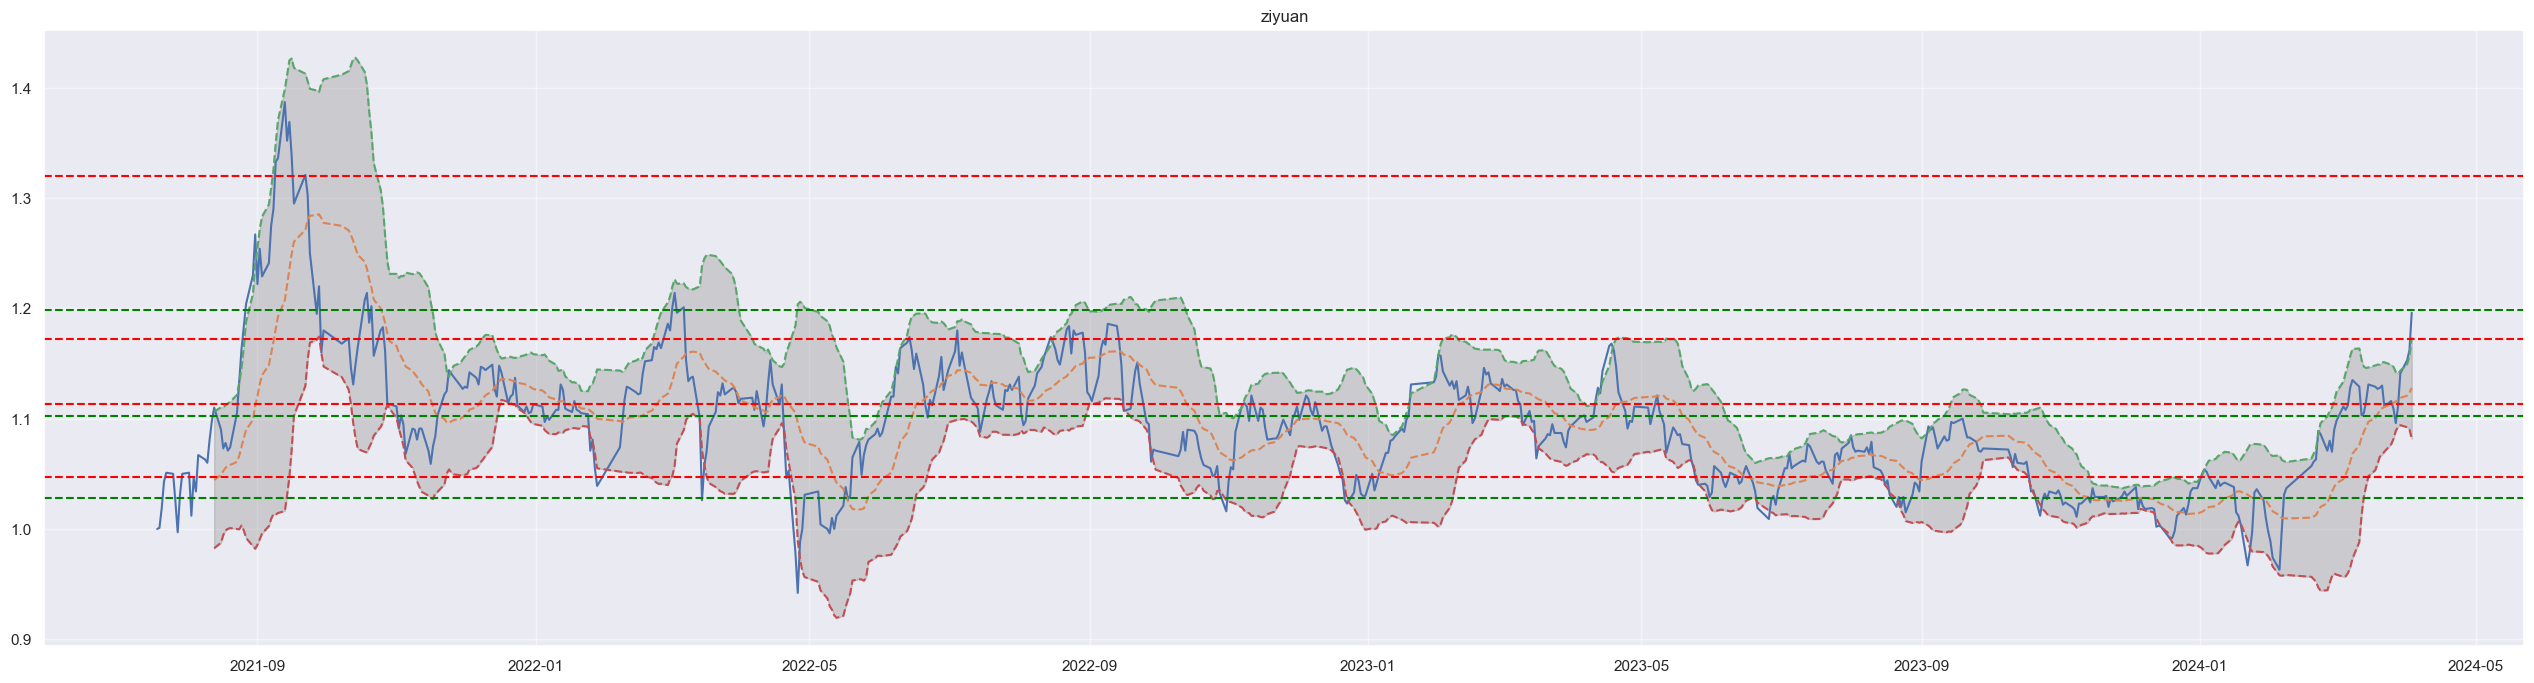

In [26]:
# sell 1.19; solid buy 1.1
print(df_fund["name"].unique().tolist()[12])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[12]])

beizheng 50
2024-04-04
* previous stock price closing 0.91
[[0.85375714]
 [0.96636571]
 [1.05413846]]
[[0.87455789]
 [0.98022857]
 [1.08254375]]
Latest Lower Bollinger Band: 0.8893506402872061
Latest Higher Bollinger Band: 0.9710793597127937


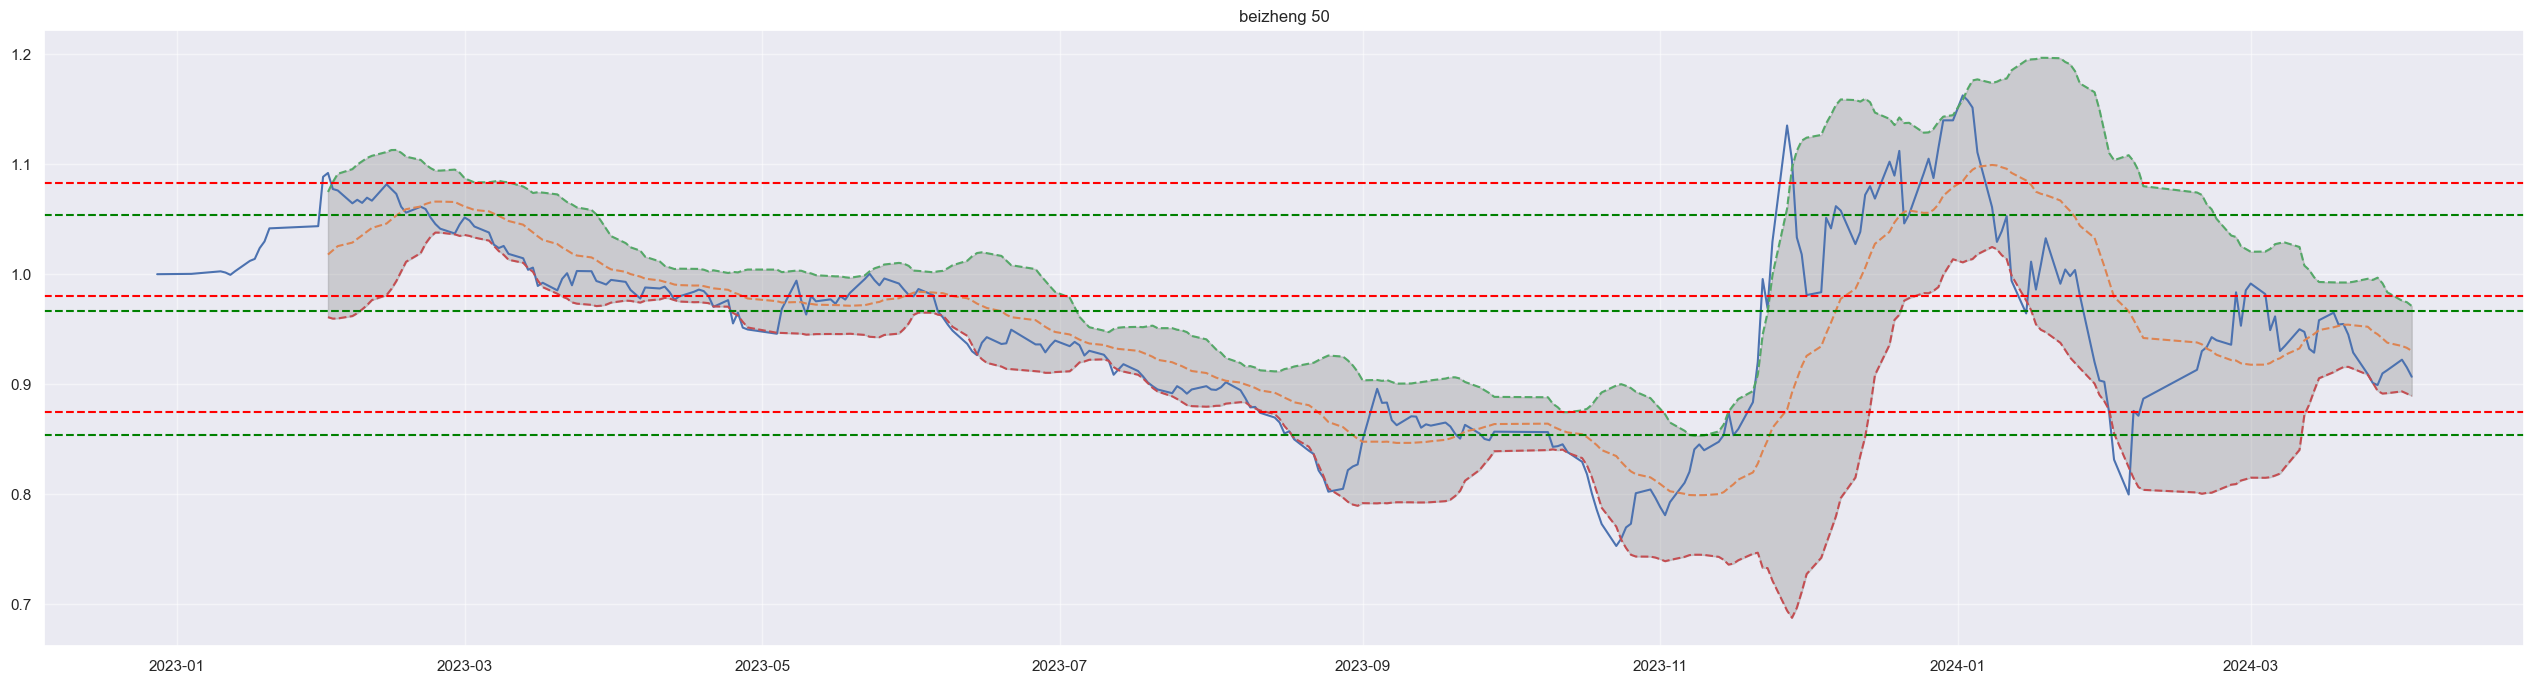

In [27]:
# Try 0.89- buy
print(df_fund["name"].unique().tolist()[19])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[19]])

In [28]:
def calculate_investment_return(stock_prices, purchase_interval, investment_amount, start_date, end_date):
    # Filter stock prices between start and end date
    stock_prices = stock_prices[stock_prices['date'].between(start_date,end_date)]
    

    # Initialize variables
    total_investment = 0
    num_shares = 0
    daily_investment_value = list()
    daily_investment_amt = list()    
    last_purchase_date = None

    # Iterate over stock prices
    for idx, row in stock_prices.iterrows():
        # Check if it's time to make a purchase
        if last_purchase_date is None or (row['date'] - last_purchase_date).days >= purchase_interval:
            # Calculate number of shares to purchase
            num_shares += investment_amount / row['price']
            total_investment += investment_amount      
            last_purchase_date = row['date']
        else:
            num_shares += 0
            total_investment += 0
        
        # Calculate daily investment value
        daily_investment_value.append(num_shares * row['price'])
        daily_investment_amt.append(total_investment)

    df_strategy = stock_prices.copy()
    df_strategy['investment_value'] = daily_investment_value
    df_strategy['investment_amt_sofar'] = daily_investment_amt
    df_strategy['revenue'] = df_strategy['investment_value'] - df_strategy['investment_amt_sofar']
    df_strategy['revenue%'] = df_strategy['revenue'] / df_strategy['investment_amt_sofar']
    return df_strategy

### 定投

In [29]:
dict_autogood_2021 = dict()
for e in df_fund["name"].unique().tolist():
#     print(e)
    df_stock = df_fund[df_fund["name"]==e].sort_values(by='date').reset_index()
    if e == 'hongli':
        df_stock['price'] = df_stock['NAV-Cum']
    else:
        df_stock['price'] = df_stock['NAV']
    if df_stock['date'].min() > pd.to_datetime('2021-01-01'):
#         print("History too short, skip")
        pass
    else:        
        stock_strategy =  calculate_investment_return(df_stock[['date','price']],
                                                      purchase_interval=7, 
                                                      investment_amount=500, 
                                                      start_date='2021-01-01', 
                                                      end_date=datetime.today().strftime('%Y-%m-%d'))
#         print(stock_strategy['revenue%'].min())
#         print(stock_strategy.iloc[-1]['revenue%'])
        if stock_strategy.iloc[-1]['revenue%'] > 0:
            dict_autogood_2021[e] = stock_strategy.iloc[-1]['revenue%']
dict_autogood_2021

{'500dibo': 0.016494429013397788,
 'jiadian': 0.004980844184721674,
 'tongxinshebei': 0.144499694852965,
 'zhongyao': 0.007838791155244263,
 'honglidibo': 0.2287470052812212,
 'hongli': 0.12460558602036947,
 'huangjinchanye': 0.30142127173232103,
 'chuanmei': 0.032571617733914135}

In [30]:
dict_autogood_2022 = dict()
for e in df_fund["name"].unique().tolist():
#     print(e)
    df_stock = df_fund[df_fund["name"]==e].sort_values(by='date').reset_index()
    if e == 'hongli':
        df_stock['price'] = df_stock['NAV-Cum']
    else:
        df_stock['price'] = df_stock['NAV']
    if df_stock['date'].min() > pd.to_datetime('2022-01-01'):
#         print("History too short, skip")
        pass
    else:
        stock_strategy =  calculate_investment_return(df_stock[['date','NAV']].rename(columns={'NAV':'price'}),
                                                      purchase_interval=7, 
                                                      investment_amount=500, 
                                                      start_date='2022-01-01', 
                                                      end_date=datetime.today().strftime('%Y-%m-%d'))
#         print(stock_strategy['revenue%'].min())
#         print(stock_strategy.iloc[-1]['revenue%'])
        if stock_strategy.iloc[-1]['revenue%'] > 0:
            dict_autogood_2022[e] = stock_strategy.iloc[-1]['revenue%']
dict_autogood_2022

{'500dibo': 0.005325819120989244,
 'jiadian': 0.06400075592978906,
 'ziyuan': 0.10478492087066882,
 'tongxinshebei': 0.15585726543428258,
 'honglidibo': 0.1535045374022298,
 'hongli': 0.04897781749776186,
 'huangjinchanye': 0.2529287121560662,
 'chuanmei': 0.06501389089270755}

### 网格

In [31]:
import sys
sys.path.append('../src') 
from utils import stock_trading_strategy
dict_gridgood_2021 = dict()

for e in df_fund["name"].unique().tolist():
#     print(e)
    df_stock = df_fund[df_fund["name"]==e].sort_values(by='date').reset_index()
    if e == 'hongli':
        df_stock['daily_price'] = df_stock['NAV-Cum']
    else:
        df_stock['daily_price'] = df_stock['NAV']
    if df_stock['date'].min() > pd.to_datetime('2021-01-01'):
#         print("History too short, skip")
        pass
    else:
        result =  stock_trading_strategy(df_stock[['date','daily_price']],
                                         start_date='2021-01-01',
                                         end_date=datetime.today().strftime('%Y-%m-%d'))
#         print((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000)
        if (result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000 > 0:
            dict_gridgood_2021[e] = (result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000
dict_gridgood_2021

{'zhongzheng 500': 543.4216676830838,
 '500dibo': 286.72796493497844,
 'bandaoti - zhongzheng': 667.6754517609861,
 'rengongzhineng': 982.4995408522773,
 'jiadian': 600.4589805851992,
 'tongxinshebei': 1733.712887020938,
 'zhongyao': 120.81979184867669,
 'honglidibo': 57.86035462797918,
 'hongli': 51.475568456700785,
 'huangjinchanye': 233.94941718200607,
 'chuanmei': 1709.0310423127194}

In [32]:
import sys
sys.path.append('../src') 
from utils import stock_trading_strategy
dict_gridgood_2022 = dict()

for e in df_fund["name"].unique().tolist():
#     print(e)
    df_stock = df_fund[df_fund["name"]==e].sort_values(by='date').reset_index()
    if e == 'hongli':
        df_stock['daily_price'] = df_stock['NAV-Cum']
    else:
        df_stock['daily_price'] = df_stock['NAV']
    if df_stock['date'].min() > pd.to_datetime('2022-01-01'):
#         print("History too short, skip")
        pass
    else:
        result =  stock_trading_strategy(df_stock[['date','daily_price']],
                                         start_date='2022-01-01',
                                         end_date=datetime.today().strftime('%Y-%m-%d'))
#         print((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000)
        if (result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000 > 0:
            dict_gridgood_2022[e] = (result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000
dict_gridgood_2022

{'zhongzheng 500': 92.30342447200928,
 '500dibo': 467.558095427381,
 'zhinengqiche': 542.9369433480642,
 'rengongzhineng': 312.73505020042285,
 'jiadian': 489.04379976109703,
 'ziyuan': 1000.496112555511,
 'tongxinshebei': 1632.7791958681282,
 'zhongyao': 686.813878088873,
 'honglidibo': 274.6751712833284,
 'hongli': 321.02622060894646,
 'huangjinchanye': 115.33622854761234,
 'chuanmei': 1400.245709388715}

##### 红利低波 - 定投
1.8 买入

2024-04-04
* previous stock price closing 1.88
[[1.35258065]
 [1.49157105]
 [1.56077391]
 [1.6982902 ]
 [1.81534444]]
[[1.36543103]
 [1.49860833]
 [1.56919298]
 [1.677244  ]
 [1.74588333]
 [1.8492875 ]]
Latest Lower Bollinger Band: 1.7968580199026651
Latest Higher Bollinger Band: 1.8811919800973351
Annual return rate: 0.1488217833490378


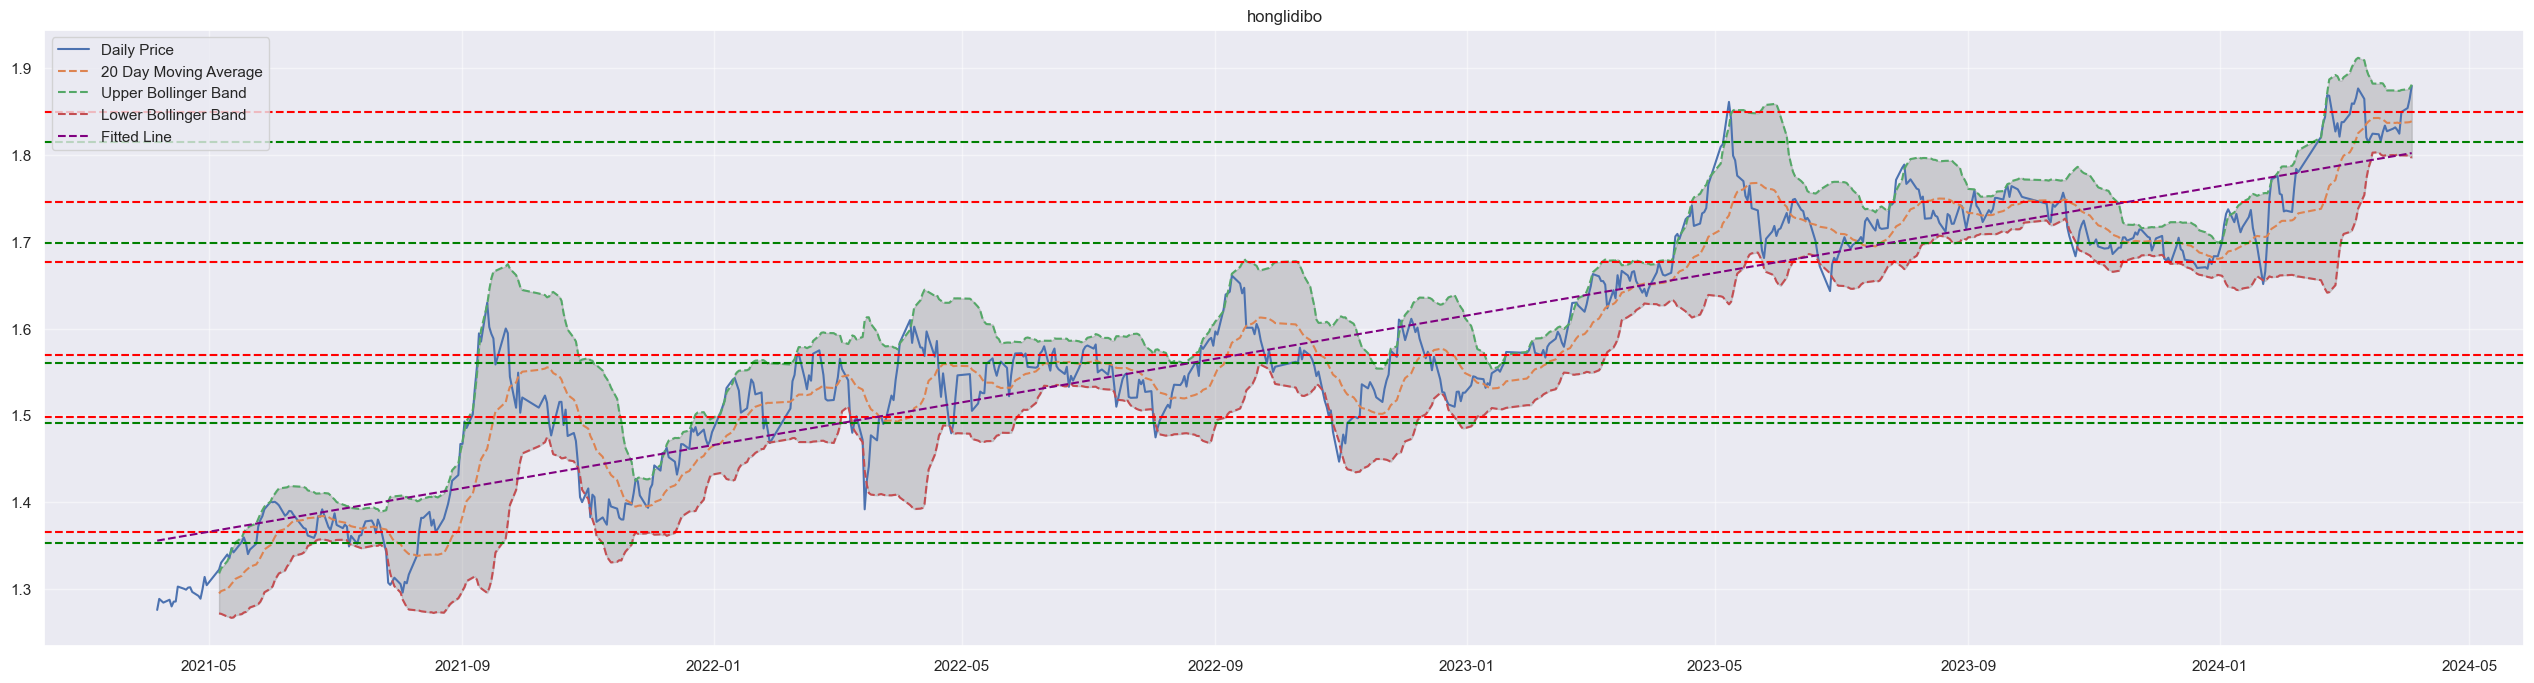

In [33]:
stock_df = df_fund[df_fund["name"]=='honglidibo']
start=(datetime.today() - relativedelta(years=3)).strftime('%Y-%m-%d')
# start=df_fund['date'].min()

df = stock_df[stock_df['date'].between(start,datetime.today().strftime('%Y-%m-%d'))]
df = df.sort_values(by='date').reset_index()
df['daily_price'] = df['NAV']

print(datetime.today().strftime('%Y-%m-%d'))
print('* previous stock price closing', round(df.iloc[-1]['daily_price'],2))

# Support and Resistance
df = identify_weak_support_resistance(df)
low_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak support'][['date',"daily_price"]].set_index('date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak resistance'][['date',"daily_price"]].set_index('date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print(low_centers)
print(high_centers)

df['20 Day MA'] = df['NAV'].rolling(window=20).mean()
df['20 Day STD'] = df['NAV'].rolling(window=20).std()
    
# Calculate upper and lower bands
df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
print("Latest Lower Bollinger Band:", df['Lower Band'].tolist()[-1])
print("Latest Higher Bollinger Band:", df['Upper Band'].tolist()[-1])

fig, ax = plt.subplots(figsize=(32,8))

# fit a trend line
df['date_numeric'] = pd.to_numeric(df['date'])
X = df['date_numeric'].values.reshape(-1, 1)  # Feature matrix (date)
y = df['NAV'].values.reshape(-1, 1)         # Target vector (price)

X_b = np.c_[np.ones((len(X), 1)), X]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

intercept, slope = theta_best[0], theta_best[1]

print("Annual return rate:", (X_b.dot(theta_best)[-1]-X_b.dot(theta_best)[0])[0]/((datetime.today()-pd.to_datetime(start)).days/365.2425))
# All time: Annual return rate: 0.11558604215459481

ax.grid(True, alpha=0.5)
ax.set_title(stock_df['name'].unique()[0])
ax.plot(df['date'], df['NAV'], label='Daily Price')
ax.plot(df['date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
ax.plot(df['date'], df['Upper Band'], ls='--', label='Upper Bollinger Band')
ax.plot(df['date'], df['Lower Band'], ls='--', label='Lower Bollinger Band')
ax.fill_between(df['date'], df['Upper Band'], df['Lower Band'], color='gray', alpha=0.3) # Fill the area between the bands

for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')
    
ax.plot(df['date'], X_b.dot(theta_best), ls='--', color='purple', label='Fitted Line')
ax.legend()
ax.grid(True)

##### 红利 - 定投

2024-04-04
* previous stock price closing 1.36
[[1.14836136]
 [1.21317123]
 [1.28442   ]]
[[1.15564848]
 [1.22238718]
 [1.29465455]]
Latest Lower Bollinger Band: 1.322004317510551
Latest Higher Bollinger Band: 1.3712056824894492
Annual return rate: 0.05201141543735611


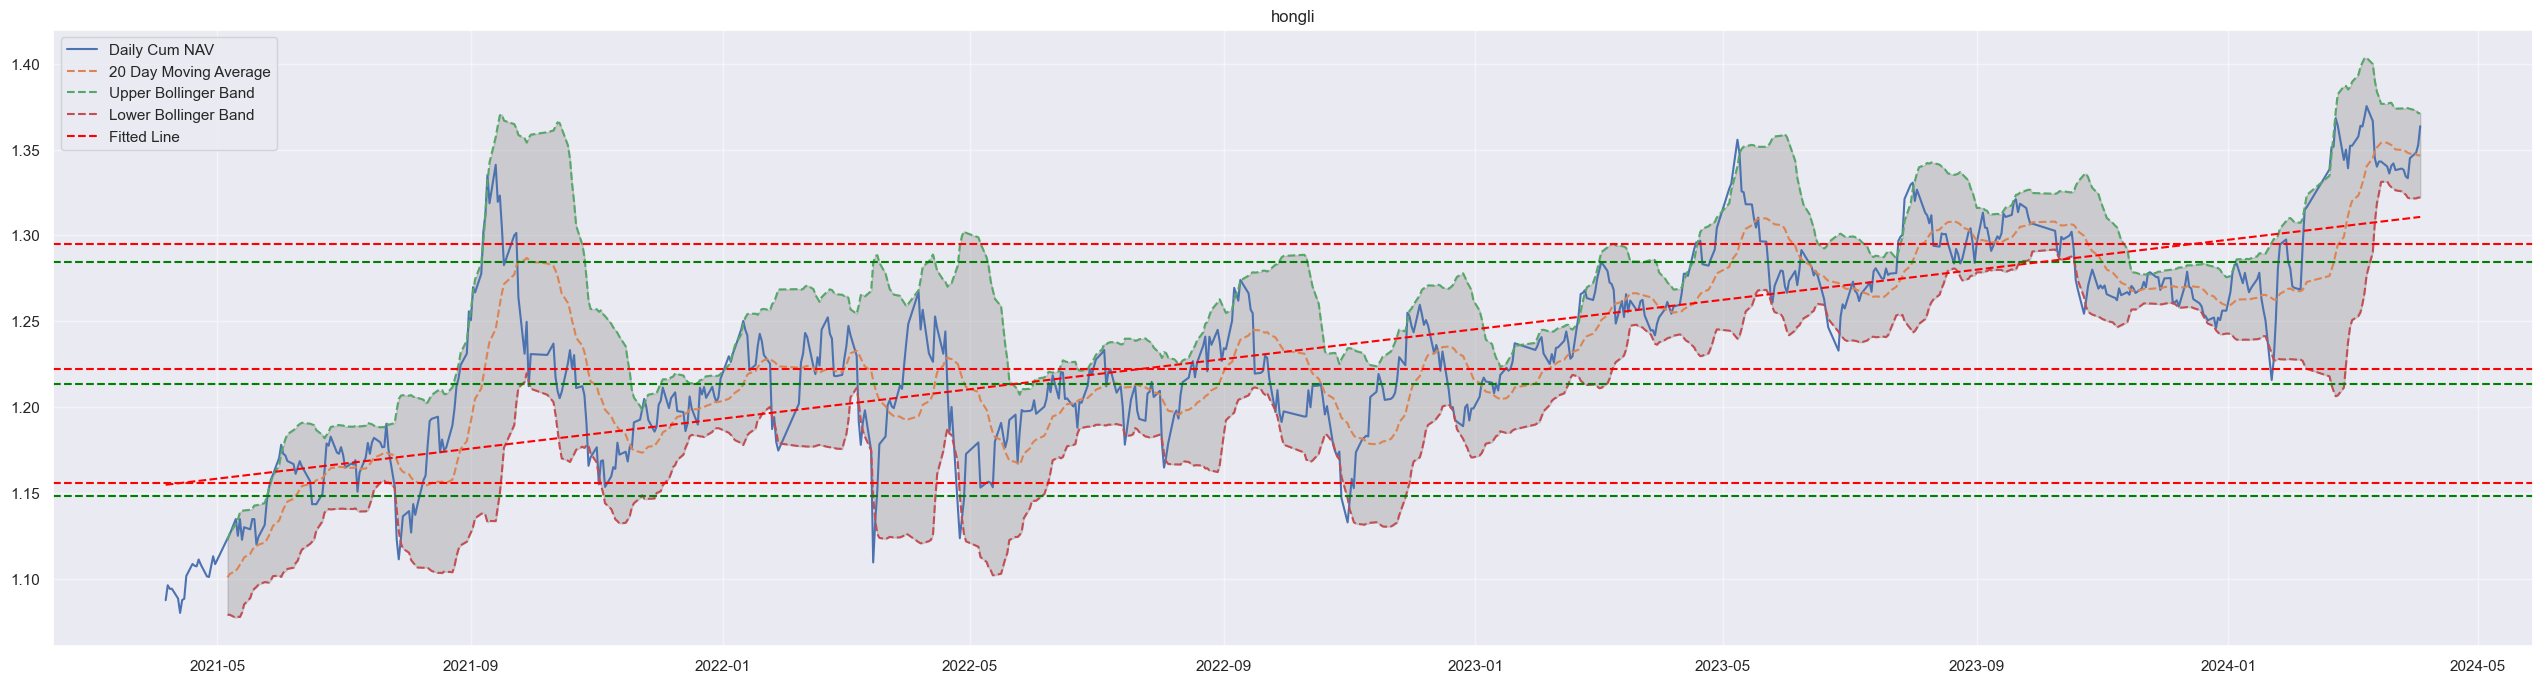

In [34]:
stock_df = df_fund[df_fund["name"]=='hongli']
start=(datetime.today() - relativedelta(years=3)).strftime('%Y-%m-%d')
# start=df_fund['date'].min()

df = stock_df[stock_df['date'].between(start,datetime.today().strftime('%Y-%m-%d'))]
df = df.sort_values(by='date').reset_index()
df['daily_price'] = df['NAV-Cum']

print(datetime.today().strftime('%Y-%m-%d'))
print('* previous stock price closing', round(df.iloc[-1]['daily_price'],2))

# Support and Resistance
df = identify_weak_support_resistance(df)
low_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak support'][['date',"daily_price"]].set_index('date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak resistance'][['date',"daily_price"]].set_index('date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print(low_centers)
print(high_centers)

# For hongli, need to use NAV-Cum
df['20 Day MA'] = df['NAV-Cum'].rolling(window=20).mean()
df['20 Day STD'] = df['NAV-Cum'].rolling(window=20).std()
    
# Calculate upper and lower bands
df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
print("Latest Lower Bollinger Band:", df['Lower Band'].tolist()[-1])
print("Latest Higher Bollinger Band:", df['Upper Band'].tolist()[-1])

fig, ax = plt.subplots(figsize=(32,8))

# fit a trend line
df['date_numeric'] = pd.to_numeric(df['date'])
X = df['date_numeric'].values.reshape(-1, 1)  # Feature matrix (date)
y = df['NAV-Cum'].values.reshape(-1, 1)         # Target vector (price)

X_b = np.c_[np.ones((len(X), 1)), X]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

intercept, slope = theta_best[0], theta_best[1]

print("Annual return rate:", (X_b.dot(theta_best)[-1]-X_b.dot(theta_best)[0])[0]/((datetime.today()-pd.to_datetime(start)).days/365.2425))
# All time: Annual return rate: 0.03184651573698018

ax.grid(True, alpha=0.5)
ax.set_title(stock_df['name'].unique()[0])
ax.plot(df['date'], df['NAV-Cum'], label='Daily Cum NAV')
ax.plot(df['date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
ax.plot(df['date'], df['Upper Band'], ls='--', label='Upper Bollinger Band')
ax.plot(df['date'], df['Lower Band'], ls='--', label='Lower Bollinger Band')
ax.fill_between(df['date'], df['Upper Band'], df['Lower Band'], color='gray', alpha=0.3) # Fill the area between the bands

for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')
    
ax.plot(df['date'], X_b.dot(theta_best), ls='--', color='red', label='Fitted Line')
ax.legend()
ax.grid(True)

##### 黄金

2024-04-04
* previous stock price closing 1.82
[[1.29452027]
 [1.38062128]
 [1.52895484]
 [1.6169    ]]
[[1.30589452]
 [1.39385306]
 [1.5477875 ]
 [1.63557857]]
Latest Lower Bollinger Band: 1.6711930400825694
Latest Higher Bollinger Band: 1.8173269599174304
Annual return rate: 0.14041132873961282


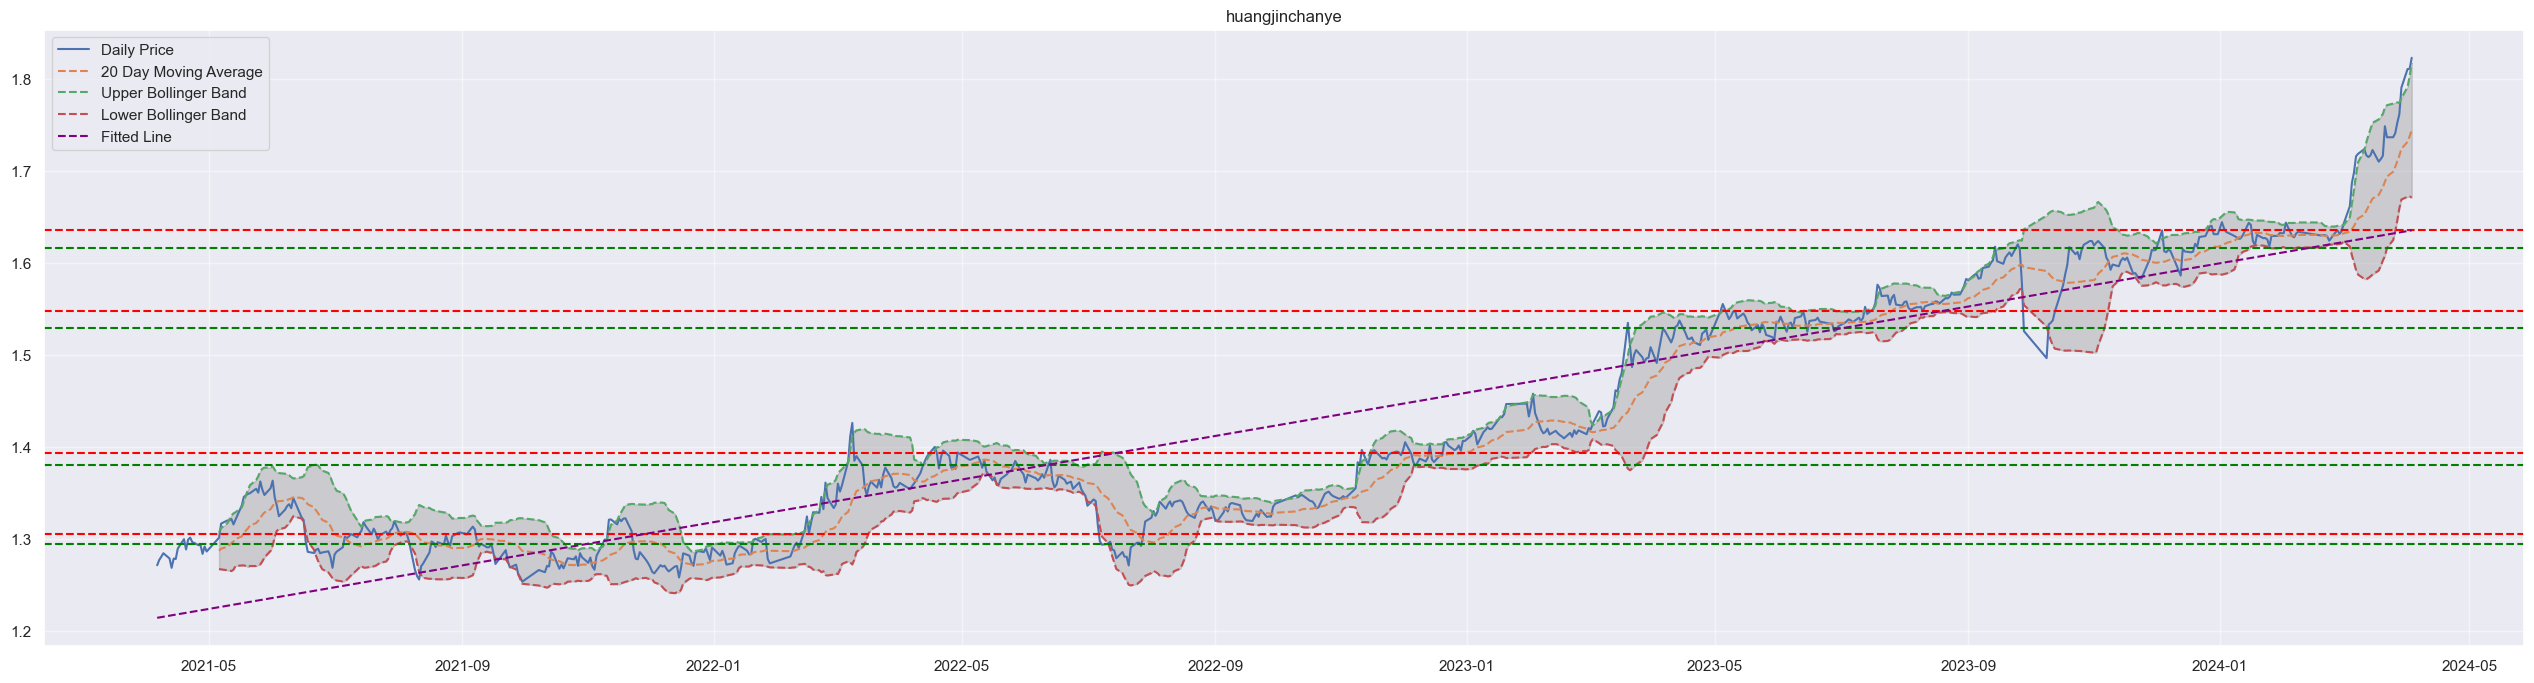

In [35]:
stock_df = df_fund[df_fund["name"]=='huangjinchanye']
start=(datetime.today() - relativedelta(years=3)).strftime('%Y-%m-%d')
# start=df_fund['date'].min()

df = stock_df[stock_df['date'].between(start,datetime.today().strftime('%Y-%m-%d'))]
df = df.sort_values(by='date').reset_index()
df['daily_price'] = df['NAV']

print(datetime.today().strftime('%Y-%m-%d'))
print('* previous stock price closing', round(df.iloc[-1]['daily_price'],2))

# Support and Resistance
df = identify_weak_support_resistance(df)
low_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak support'][['date',"daily_price"]].set_index('date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak resistance'][['date',"daily_price"]].set_index('date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print(low_centers)
print(high_centers)

df['20 Day MA'] = df['NAV'].rolling(window=20).mean()
df['20 Day STD'] = df['NAV'].rolling(window=20).std()
    
# Calculate upper and lower bands
df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
print("Latest Lower Bollinger Band:", df['Lower Band'].tolist()[-1])
print("Latest Higher Bollinger Band:", df['Upper Band'].tolist()[-1])

fig, ax = plt.subplots(figsize=(32,8))

# fit a trend line
df['date_numeric'] = pd.to_numeric(df['date'])
X = df['date_numeric'].values.reshape(-1, 1)  # Feature matrix (date)
y = df['NAV'].values.reshape(-1, 1)         # Target vector (price)

X_b = np.c_[np.ones((len(X), 1)), X]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

intercept, slope = theta_best[0], theta_best[1]

print("Annual return rate:", (X_b.dot(theta_best)[-1]-X_b.dot(theta_best)[0])[0]/((datetime.today()-pd.to_datetime(start)).days/365.2425))
# All time: Annual return rate: 0.07699482486915966

ax.grid(True, alpha=0.5)
ax.set_title(stock_df['name'].unique()[0])
ax.plot(df['date'], df['NAV'], label='Daily Price')
ax.plot(df['date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
ax.plot(df['date'], df['Upper Band'], ls='--', label='Upper Bollinger Band')
ax.plot(df['date'], df['Lower Band'], ls='--', label='Lower Bollinger Band')
ax.fill_between(df['date'], df['Upper Band'], df['Lower Band'], color='gray', alpha=0.3) # Fill the area between the bands

for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')
    
ax.plot(df['date'], X_b.dot(theta_best), ls='--', color='purple', label='Fitted Line')
ax.legend()
ax.grid(True)

### Conclusion:
* 红利低波\红利 定投
* 通信设备、资源、传媒 网格
* 黄金产业 allin

In [36]:
def test_grid(stock_list, th1, th2, m, start_date='2021-01-01'):
    today_date = datetime.today().strftime('%Y-%m-%d')
    initial_cash = 10000
    investment = 1000
    list_stock = []
    list_profit = []
    list_max_loss = []
    list_number_actions = []
    list_minimal_cash_reserve = []
    list_price_change = []
#     for stock_name in dict_gridgood_2021:
    for stock_name in stock_list:
        stock_df = df_fund[df_fund["name"]==stock_name].sort_values(by='date').reset_index()[['date','NAV']].rename(columns={'NAV':'daily_price'})
        result = stock_trading_strategy(stock_df, start_date, today_date, initial_cash, investment, th1, th2, m)
        profit = ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-initial_cash)
        underlying_stock_price_change = (result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']
        max_loss = (result['total_stock_value']+result['total_cash']).min() - initial_cash
        number_actions = result[result['action'].isin(['Purchase','Sell'])].shape[0]
        minimal_cash_reserve = result['total_cash'].min()
        list_stock.append(stock_name)
        list_profit.append(profit)
        list_price_change.append(underlying_stock_price_change)
        list_max_loss.append(max_loss)
        list_minimal_cash_reserve.append(minimal_cash_reserve)
        list_number_actions.append(number_actions)

    df_all_stock = pd.DataFrame(
        {
            'stock_name': list_stock,
            'start_date': [start_date]*len(list_stock),
            'end_date': [today_date]*len(list_stock),
            'initial_cash': [initial_cash]*len(list_stock),
            'investment': [investment]*len(list_stock),
            'buy_threshold': [th1]*len(list_stock),
            'sell_threshold': [th2]*len(list_stock),
            'multiplier': [m]*len(list_stock),
            'profit': list_profit,
            'underlying_stock_price_change': list_price_change,
            'max_loss': list_max_loss,
            'minimal_cash_reserve': list_minimal_cash_reserve,
            'number_actions': list_number_actions
        }
    )
    print('Numbers of stock tested:', len(list_stock))
    print(df_all_stock.shape)
    return df_all_stock

In [37]:
strategy_dfs_2021 = []
for th1 in [0.05, 0.07, 0.1]:
    for th2 in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
        for m in [1, 1.05]:
            df_strategy = test_grid(list(dict_gridgood_2021.keys()), th1, th2, m)
            strategy_dfs_2021.append(df_strategy)

Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
N

In [38]:
good_dfs_2021 = []
for df in strategy_dfs_2021:
    good_dfs_2021.append(df[(df['profit']>=1000)&(df['max_loss']>=-1000)])
good_df_2021 = pd.concat(good_dfs_2021)
print(good_df_2021.shape)
good_df_2021.head()

(41, 13)


stock_name  start_date    end_date  initial_cash  investment  \
5  tongxinshebei  2021-01-01  2024-04-04         10000        1000   
5  tongxinshebei  2021-01-01  2024-04-04         10000        1000   
5  tongxinshebei  2021-01-01  2024-04-04         10000        1000   
5  tongxinshebei  2021-01-01  2024-04-04         10000        1000   
5  tongxinshebei  2021-01-01  2024-04-04         10000        1000   

   buy_threshold  sell_threshold  multiplier       profit  \
5           0.05            0.05        1.00  1733.712887   
5           0.05            0.05        1.05  2227.771519   
5           0.05            0.10        1.00  1781.856635   
5           0.05            0.10        1.05  2178.923078   
5           0.05            0.15        1.00  2460.234380   

   underlying_stock_price_change    max_loss  minimal_cash_reserve  \
5                        0.06814 -607.268649           4393.187923   
5                        0.06814 -707.911907           3288.230753   
5                        0.06814 -713.175903           4308.625447   
5                        0.06814 -806.701204           3248.314818   
5                        0.06814 -732.457151           4321.106070   

   number_actions  
5              58  
5              58  
5              32  
5              32  
5              30

In [39]:
good_df_2021[["stock_name", "underlying_stock_price_change"]].drop_duplicates()

stock_name  underlying_stock_price_change
5           tongxinshebei                       0.068140
10               chuanmei                      -0.136653
2   bandaoti - zhongzheng                      -0.322145
3          rengongzhineng                      -0.297822

In [40]:
good_df_2021[
  (good_df_2021['max_loss']>=-1000)
  &
  (good_df_2021['profit']>1000)
][["stock_name", "buy_threshold", "sell_threshold", "multiplier", "profit", "max_loss", "minimal_cash_reserve"]].sort_values(by='profit', ascending=False)

stock_name  buy_threshold  sell_threshold  multiplier  \
5           tongxinshebei           0.05            0.25        1.05   
5           tongxinshebei           0.05            0.15        1.05   
5           tongxinshebei           0.05            0.25        1.00   
5           tongxinshebei           0.05            0.20        1.05   
5           tongxinshebei           0.05            0.15        1.00   
5           tongxinshebei           0.07            0.25        1.05   
5           tongxinshebei           0.05            0.05        1.05   
5           tongxinshebei           0.05            0.20        1.00   
5           tongxinshebei           0.05            0.10        1.05   
10               chuanmei           0.07            0.10        1.05   
5           tongxinshebei           0.07            0.30        1.05   
5           tongxinshebei           0.07            0.20        1.05   
5           tongxinshebei           0.07            0.25        1.00   
5           tongxinshebei           0.07            0.15        1.05   
10               chuanmei           0.10            0.25        1.05   
5           tongxinshebei           0.05            0.10        1.00   
5           tongxinshebei           0.07            0.30        1.00   
5           tongxinshebei           0.07            0.20        1.00   
5           tongxinshebei           0.05            0.05        1.00   
10               chuanmei           0.07            0.10        1.00   
5           tongxinshebei           0.07            0.15        1.00   
5           tongxinshebei           0.07            0.10        1.05   
10               chuanmei           0.10            0.25        1.00   
5           tongxinshebei           0.10            0.25        1.05   
5           tongxinshebei           0.10            0.30        1.05   
5           tongxinshebei           0.10            0.15        1.05   
5           tongxinshebei           0.07            0.05        1.05   
5           tongxinshebei           0.07            0.10        1.00   
5           tongxinshebei           0.10            0.25        1.00   
5           tongxinshebei           0.10            0.15        1.00   
5           tongxinshebei           0.10            0.30        1.00   
5           tongxinshebei           0.10            0.20        1.05   
10               chuanmei           0.10            0.05        1.05   
5           tongxinshebei           0.07            0.05        1.00   
5           tongxinshebei           0.10            0.20        1.00   
10               chuanmei           0.10            0.10        1.05   
3          rengongzhineng           0.10            0.20        1.05   
10               chuanmei           0.10            0.05        1.00   
5           tongxinshebei           0.10            0.05        1.05   
10               chuanmei           0.10            0.10        1.00   
2   bandaoti - zhongzheng           0.07            0.30        1.05   

         profit    max_loss  minimal_cash_reserve  
5   3239.506791 -845.608287           3489.345214  
5   2915.004478 -779.750151           3560.754553  
5   2699.760296 -796.928483           4251.599634  
5   2651.959976 -904.336064           3430.617438  
5   2460.234380 -732.457151           4321.106070  
5   2254.712085 -883.704986           4474.368750  
5   2227.771519 -707.911907           3288.230753  
5   2218.396676 -847.659744           4200.868373  
5   2178.923078 -806.701204           3248.314818  
10  2094.762007 -982.523243           2503.959602  
5   2027.200970 -883.704986           4474.368750  
5   2014.711479 -623.790163           4710.422899  
5   1970.329557 -833.082154           5000.000000  
5   1822.170004 -687.352791           4646.860272  
10  1790.977940 -982.281671           4776.395221  
5   1781.856635 -713.175903           4308.625447  
5   1776.380359 -833.082154           5000.000000  
5   1770.408913 -597.957919           5214.108071  
5 

In [41]:
good_df_2021[
  (good_df_2021['max_loss']>=-1000)
  &
  (good_df_2021['profit']>1500)
][["stock_name", "buy_threshold", "sell_threshold", "multiplier", "profit", "max_loss", "minimal_cash_reserve"]].sort_values(by='profit', ascending=False)

stock_name  buy_threshold  sell_threshold  multiplier       profit  \
5   tongxinshebei           0.05            0.25        1.05  3239.506791   
5   tongxinshebei           0.05            0.15        1.05  2915.004478   
5   tongxinshebei           0.05            0.25        1.00  2699.760296   
5   tongxinshebei           0.05            0.20        1.05  2651.959976   
5   tongxinshebei           0.05            0.15        1.00  2460.234380   
5   tongxinshebei           0.07            0.25        1.05  2254.712085   
5   tongxinshebei           0.05            0.05        1.05  2227.771519   
5   tongxinshebei           0.05            0.20        1.00  2218.396676   
5   tongxinshebei           0.05            0.10        1.05  2178.923078   
10       chuanmei           0.07            0.10        1.05  2094.762007   
5   tongxinshebei           0.07            0.30        1.05  2027.200970   
5   tongxinshebei           0.07            0.20        1.05  2014.711479   
5   tongxinshebei           0.07            0.25        1.00  1970.329557   
5   tongxinshebei           0.07            0.15        1.05  1822.170004   
10       chuanmei           0.10            0.25        1.05  1790.977940   
5   tongxinshebei           0.05            0.10        1.00  1781.856635   
5   tongxinshebei           0.07            0.30        1.00  1776.380359   
5   tongxinshebei           0.07            0.20        1.00  1770.408913   
5   tongxinshebei           0.05            0.05        1.00  1733.712887   
10       chuanmei           0.07            0.10        1.00  1702.903757   
5   tongxinshebei           0.07            0.15        1.00  1619.877015   
5   tongxinshebei           0.07            0.10        1.05  1587.892595   
10       chuanmei           0.10            0.25        1.00  1540.651700   
5   tongxinshebei           0.10            0.25        1.05  1512.026714   

      max_loss  minimal_cash_reserve  
5  -845.608287           3489.345214  
5  -779.750151           3560.754553  
5  -796.928483           4251.599634  
5  -904.336064           3430.617438  
5  -732.457151           4321.106070  
5  -883.704986           4474.368750  
5  -707.911907           3288.230753  
5  -847.659744           4200.868373  
5  -806.701204           3248.314818  
10 -982.523243           2503.959602  
5  -883.704986           4474.368750  
5  -623.790163           4710.422899  
5  -833.082154           5000.000000  
5  -687.352791           4646.860272  
10 -982.281671           4776.395221  
5  -713.175903           4308.625447  
5  -833.082154           5000.000000  
5  -597.957919           5214.108071  
5  -607.268649           4393.187923  
10 -930.904538           3561.779904  
5  -655.611095           5156.454895  
5  -624.636441           4710.326314  
10 -929.477310           5273.946913  
5  -634.118427           5689.875000

In [42]:
strategy_dfs_2022 = []
for th1 in [0.05, 0.07, 0.1]:
    for th2 in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
        for m in [1, 1.05]:
            df_strategy = test_grid(list(dict_gridgood_2022.keys()), th1, th2, m, start_date='2022-01-01')
            strategy_dfs_2022.append(df_strategy)

Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
N

In [43]:
good_dfs_2022 = []
for df in strategy_dfs_2022:
    good_dfs_2022.append(df[(df['profit']>=1000)&(df['max_loss']>=-1000)])
good_dfs_2022 = pd.concat(good_dfs_2022)
print(good_dfs_2022.shape)
good_dfs_2022.head()

(27, 13)


stock_name  start_date    end_date  initial_cash  investment  \
5         ziyuan  2022-01-01  2024-04-04         10000        1000   
5         ziyuan  2022-01-01  2024-04-04         10000        1000   
7       zhongyao  2022-01-01  2024-04-04         10000        1000   
6  tongxinshebei  2022-01-01  2024-04-04         10000        1000   
6  tongxinshebei  2022-01-01  2024-04-04         10000        1000   

   buy_threshold  sell_threshold  multiplier       profit  \
5           0.05            0.05        1.00  1000.496113   
5           0.05            0.05        1.05  1042.860225   
7           0.05            0.10        1.05  1127.953421   
6           0.07            0.05        1.00  1060.589776   
6           0.07            0.05        1.05  1219.739351   

   underlying_stock_price_change    max_loss  minimal_cash_reserve  \
5                       0.076508  -79.972357           7667.648059   
5                       0.076508  -80.730651           7534.738942   
7                      -0.150591 -651.169025           3589.567091   
6                       0.013183 -927.537576           5000.000000   
6                       0.013183 -982.683052           4474.368750   

   number_actions  
5              34  
5              34  
7              26  
6              34  
6              34

In [44]:
good_dfs_2022[["stock_name", "underlying_stock_price_change"]].drop_duplicates()

stock_name  underlying_stock_price_change
5          ziyuan                       0.076508
7        zhongyao                      -0.150591
6   tongxinshebei                       0.013183
11       chuanmei                      -0.155815

In [45]:
good_dfs_2022[
  (good_dfs_2022['max_loss']>=-1000)
  &
  (good_dfs_2022['profit']>1000)
][["stock_name", "buy_threshold", "sell_threshold", "multiplier", "profit", "max_loss", "minimal_cash_reserve"]].sort_values(by='profit', ascending=False)

stock_name  buy_threshold  sell_threshold  multiplier       profit  \
6   tongxinshebei           0.07            0.30        1.05  2334.381613   
6   tongxinshebei           0.07            0.25        1.05  2039.486062   
6   tongxinshebei           0.07            0.15        1.05  2035.192211   
6   tongxinshebei           0.07            0.30        1.00  2002.129303   
6   tongxinshebei           0.07            0.20        1.05  1773.153459   
6   tongxinshebei           0.07            0.25        1.00  1748.823786   
6   tongxinshebei           0.07            0.15        1.00  1732.683886   
6   tongxinshebei           0.07            0.10        1.05  1705.625702   
6   tongxinshebei           0.10            0.30        1.05  1546.678368   
6   tongxinshebei           0.07            0.20        1.00  1524.259503   
6   tongxinshebei           0.07            0.10        1.00  1479.324570   
6   tongxinshebei           0.10            0.30        1.00  1388.985918   
6   tongxinshebei           0.10            0.25        1.05  1366.552392   
6   tongxinshebei           0.10            0.15        1.05  1319.244378   
6   tongxinshebei           0.10            0.25        1.00  1227.286441   
6   tongxinshebei           0.07            0.05        1.05  1219.739351   
6   tongxinshebei           0.10            0.15        1.00  1205.002533   
6   tongxinshebei           0.10            0.20        1.05  1166.735709   
11       chuanmei           0.10            0.05        1.05  1155.169443   
6   tongxinshebei           0.10            0.10        1.05  1128.573224   
7        zhongyao           0.05            0.10        1.05  1127.953421   
6   tongxinshebei           0.07            0.05        1.00  1060.589776   
6   tongxinshebei           0.10            0.10        1.00  1059.461571   
6   tongxinshebei           0.10            0.20        1.00  1049.256807   
5          ziyuan           0.05            0.05        1.05  1042.860225   
11       chuanmei           0.10            0.05        1.00  1008.543047   
5          ziyuan           0.05            0.05        1.00  1000.496113   

      max_loss  minimal_cash_reserve  
6  -982.683052           4474.368750  
6  -982.683052           4474.368750  
6  -982.683052           4474.368750  
6  -927.537576           5000.000000  
6  -982.683052           4474.368750  
6  -927.537576           5000.000000  
6  -927.537576           5000.000000  
6  -982.683052           4474.368750  
6  -779.074665           5689.875000  
6  -927.537576           5000.000000  
6  -927.537576           5000.000000  
6  -748.424293           6000.000000  
6  -779.074665           5689.875000  
6  -779.074665           5689.875000  
6  -748.424293           6000.000000  
6  -982.683052           4474.368750  
6  -748.424293           6000.000000  
6  -779.074665           5689.875000  
11 -977.895028           4668.649828  
6  -779.074665           5689.875000  
7  -651.169025           3589.567091  
6  -927.537576           5000.000000  
6  -748.424293           6000.000000  
6  -748.424293           6000.000000  
5   -80.730651           7534.738942  
11 -940.074962           5167.827300  
5   -79.972357           7667.648059

2024-04-04
* previous stock price closing 1.11
[[0.82043548]
 [0.90902917]
 [0.988442  ]
 [1.06127179]
 [1.17591667]]
[[0.84474375]
 [0.92966136]
 [1.00637292]
 [1.08552045]
 [1.21635385]]
Latest Lower Bollinger Band: 1.0897738064961726
Latest Higher Bollinger Band: 1.2221461935038271


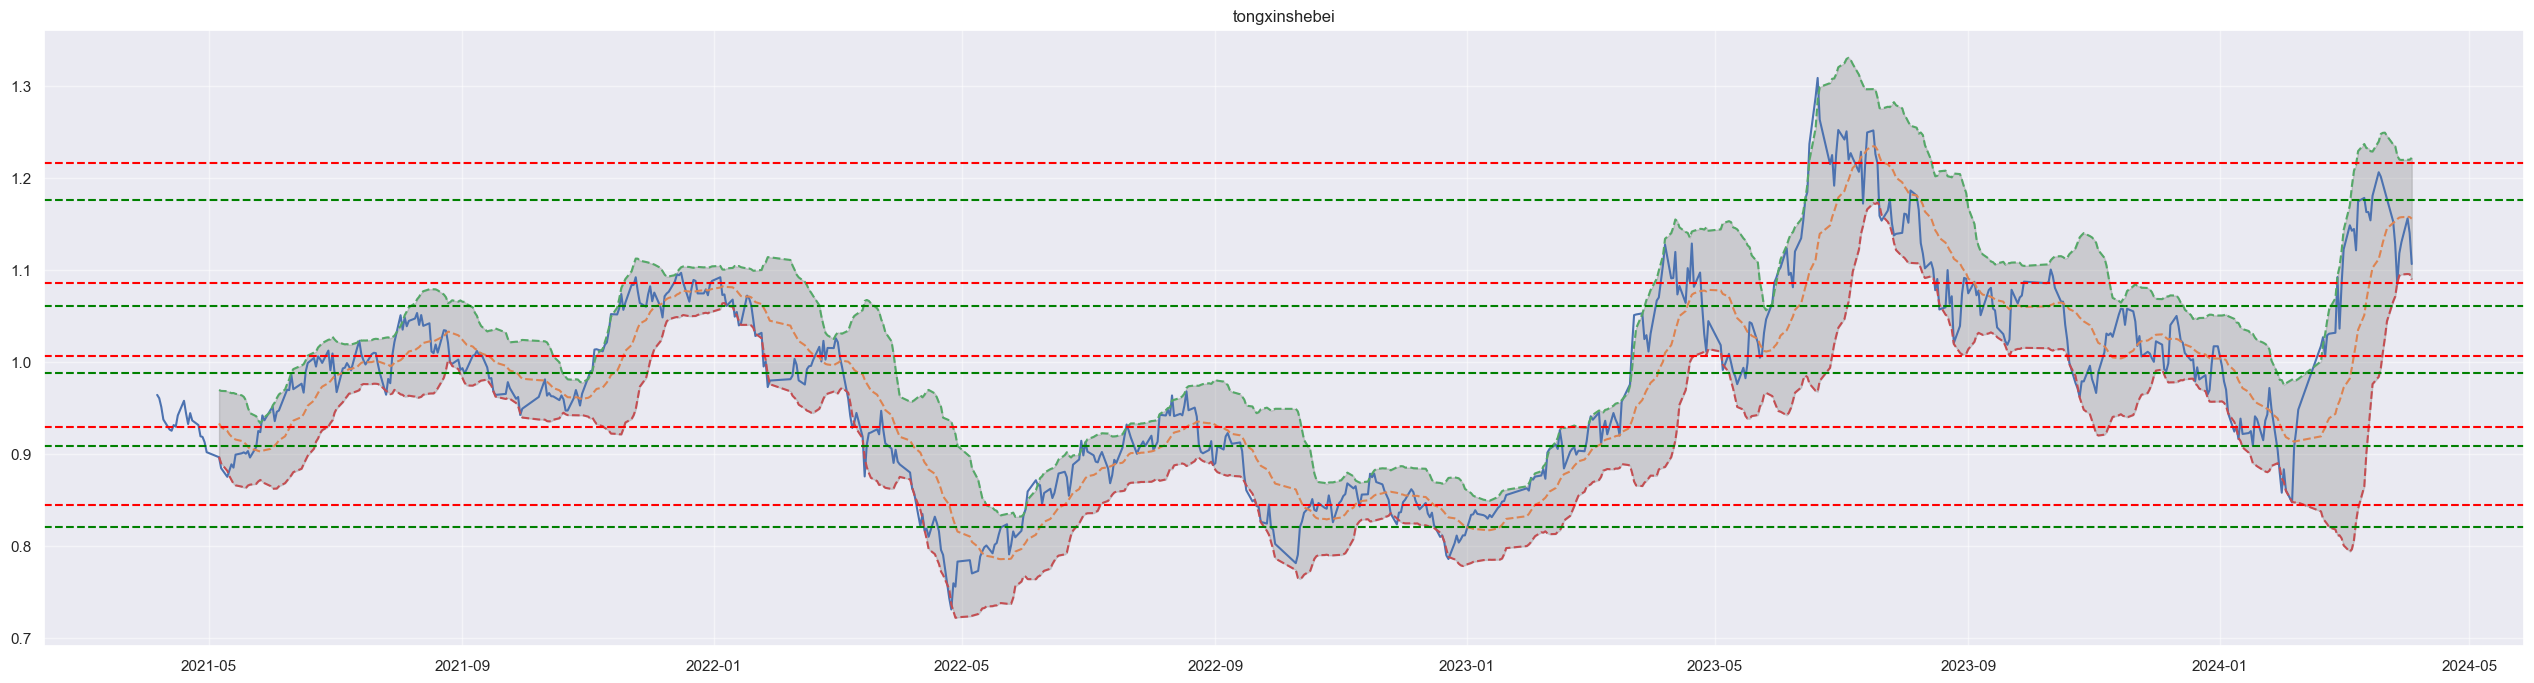

In [46]:
# begin buy 1.06
stock_bollinger_move(df_fund[df_fund["name"]=='tongxinshebei'])